# Biblioteca

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta, date
from itertools import product
from functools import reduce


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## tirar os warnings nao eh uma boa pratica, mas como os avisos ja foram mapeados
## optou-se por retira-los pra manter o codigo mais limpo e coeso
import warnings 
warnings.filterwarnings("ignore")

# Acessando arquivos


In [2]:
clusters = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/clusters_18medoids.xlsx')
dict_ = {}
for dic in range((clusters.shape[0])):
    # print(dic)
    dict_[clusters['clusters'][dic]] = clusters['medoids'][dic]
# dict_

In [3]:
# abrindo arquivos
viagens_validas = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/matriz_junho_mapeada.xlsx', index_col='Unnamed: 0')

#renomeia colunas
viagens_validas.columns = ['index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'latitudeI', 'longitudeI',
       'latitudeF', 'longitudeF', 'Nome_PontoI', 'Nome_PontoF', 'PontoFinal',
       'dist_PontoF', 'PontoInicial', 'dist_PontoI']

# reordena colunas
viagens_validas = viagens_validas[[  'index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'PontoInicial','Nome_PontoI','latitudeI', 'longitudeI','dist_PontoI',
       'PontoFinal','Nome_PontoF','latitudeF', 'longitudeF',  'dist_PontoF'  ]]

# ajusta numero do ponto ao dicionario de pontos 
viagens_validas['PontoInicial']    = viagens_validas['PontoInicial']    -1
viagens_validas['PontoFinal']      = viagens_validas['PontoFinal']      -1

viagens_validas['NEW_PontoInicial'] = viagens_validas['PontoInicial'].map(dict_)
viagens_validas['NEW_PontoFinal']   = viagens_validas['PontoFinal'].map(dict_)

viagens_validas['NEW_PontoInicial']  = viagens_validas['NEW_PontoInicial'].astype(int) 
viagens_validas['NEW_PontoFinal']    = viagens_validas['NEW_PontoFinal']  .astype(int) 

viagens_validas['day_of_week'] = viagens_validas.dataInicio.dt.day_of_week

# Volumes por OD

## Organizacao dos volumes por OD da serie temporal

- muitas ODs nao tem viagens de todos pra todos os 18 pontos (ou seja, nem todo dia tem viagem de 18 x 18)

- os dados serao organizados de forma que todos os pares ODs estejam com todos os dias e volumes da serie historica no seguinte formato:

| PAR OD 	| DATA  	| VOLUME OD 	|
|--------	|-------	|-----------	|
| 1_1    	| 01/06 	| 2         	|
| 1_1    	| 02/06 	| 0         	|
| .      	| .     	| .         	|
| 15_20  	| 16/07 	| 1         	|
| .      	| .     	| .         	|
| 33_33  	| 30/08 	| 1         	|
| 33_33  	| 31/08 	| 4         	|

- O desenvolvimentoa baixo agrupa as viagens pelos seus dias e pelos pontos de partida e chegada das viagens
- Em seguida os dados sao pivotados para o formato de tabelas ODs diárias
- Por fim os dados sao reorganizados no formato descrito acima

In [4]:
viagens_validas

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),PontoInicial,...,longitudeI,dist_PontoI,PontoFinal,Nome_PontoF,latitudeF,longitudeF,dist_PontoF,NEW_PontoInicial,NEW_PontoFinal,day_of_week
0,None_6,1,0,Manha,2021-06-01 06:44:02,2021-06-01 06:45:20,1,333.068136,78.0,33,...,-47.061214,0.001096,29,Escola Sérgio P. Porto (PONTO INICIAL),-22.829490,-47.060281,0.000124,33,33,1
1,None_6,1,0,Manha,2021-06-01 07:58:17,2021-06-01 07:59:35,4,362.164440,78.0,34,...,-47.061207,0.001011,29,Escola Sérgio P. Porto (PONTO FINAL),-22.829638,-47.060359,0.000179,33,33,1
2,None_6,1,0,Manha,2021-06-01 09:06:10,2021-06-01 09:07:28,6,350.063969,78.0,33,...,-47.061166,0.000957,29,Escola Sérgio P. Porto (PONTO INICIAL),-22.829648,-47.060414,0.000180,33,33,1
3,None_6,1,0,Manha,2021-06-01 11:10:03,2021-06-01 11:11:21,7,361.522224,78.0,34,...,-47.061240,0.001020,29,Escola Sérgio P. Porto (PONTO FINAL),-22.829614,-47.060350,0.000153,33,33,1
4,None_6,1,0,Manha,2021-06-01 11:57:21,2021-06-01 11:58:42,9,339.187065,81.0,33,...,-47.061172,0.000860,29,Escola Sérgio P. Porto (PONTO INICIAL),-22.829681,-47.060513,0.000156,33,33,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14483,None_8,31,92524,Manha,2021-08-31 12:57:57,2021-08-31 12:59:37,1,527.011253,100.0,13,...,-47.064937,0.000081,11,CECOM,-22.825647,-47.066167,0.001011,13,10,1
14484,None_8,31,93049,Tarde,2021-08-31 15:31:56,2021-08-31 15:33:16,1,825.952595,80.0,25,...,-47.067667,0.001754,13,Sobrapar,-22.831246,-47.063677,0.001125,17,13,1
14485,None_8,31,93049,Tarde,2021-08-31 15:31:56,2021-08-31 15:33:16,2,825.952595,80.0,25,...,-47.067667,0.001754,13,Sobrapar,-22.831246,-47.063677,0.001125,17,13,1
14486,None_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,13,...,-47.063912,0.000265,10,CECOM,-22.824985,-47.065243,0.001511,13,10,1


### Dados totais

In [5]:
vol_semanal = viagens_validas.groupby([ pd.Grouper(freq='1D',key = 'dataInicio')]).agg({'sequence':'count'}).reset_index()

vol_semanal.columns = [	'Data',	'Volume']
vol_semanal = vol_semanal.loc[(vol_semanal['Volume'] != 0) &  (vol_semanal['Volume'] != 1)].reset_index(drop=True)

vol_semanal

,Data,Volume
0,2021-06-01,139
1,2021-06-02,290
2,2021-06-07,241
3,2021-06-08,311
4,2021-06-09,291
...,...,...
58,2021-08-25,244
59,2021-08-26,290
60,2021-08-27,279
61,2021-08-30,221


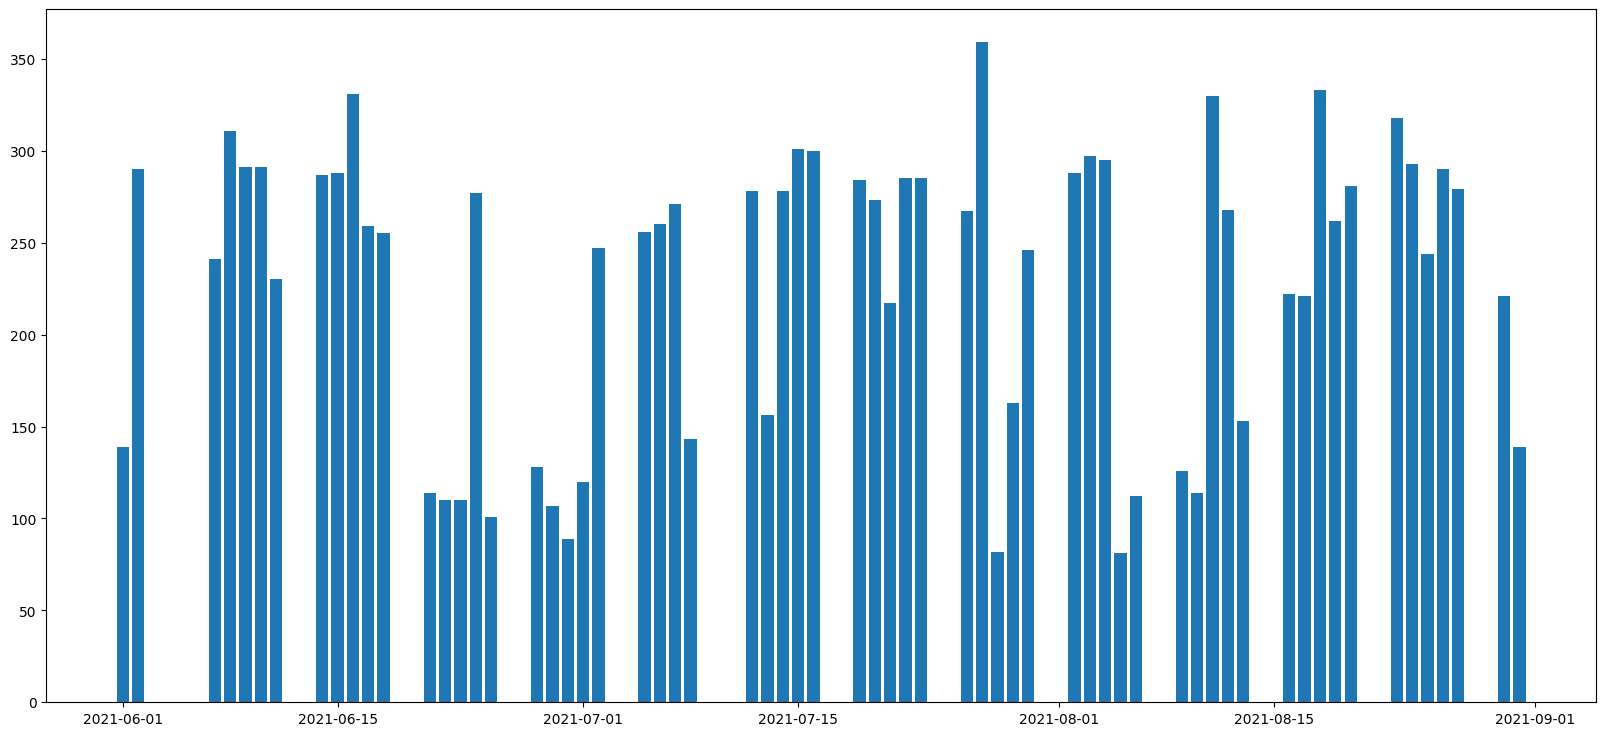

In [6]:
plt.rcParams["figure.figsize"] = (20,9)
plt.bar(vol_semanal.Data, vol_semanal.Volume)
plt.show()

In [7]:
agrupamento = viagens_validas.groupby([pd.Grouper(freq='1D',key = 'dataInicio'),'NEW_PontoInicial','NEW_PontoFinal']).agg({'sequence':'count'}).reset_index()
agrupamento.columns = ['Data',	'PontoInicial',	'PontoFinal',	'Volume']
agrupamento


,Data,PontoInicial,PontoFinal,Volume
0,2021-06-01,1,6,2
1,2021-06-01,1,10,2
2,2021-06-01,1,17,3
3,2021-06-01,1,20,3
4,2021-06-01,1,23,4
...,...,...,...,...
5110,2021-08-31,32,31,1
5111,2021-08-31,33,13,1
5112,2021-08-31,33,15,1
5113,2021-08-31,33,17,3


### Validacao dos dados totais agora em matrizes OD

In [8]:
data__ = datetime(2021,6,1)

for day in range(10):

    print('===============',data__,'===============')
    print(agrupamento.loc[agrupamento['Data'] == data__].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0).sum().sum())
    print(agrupamento.loc[agrupamento['Data'] == data__].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0).shape)

    data__ = data__ + timedelta(days=1)

=============== 2021-06-01 00:00:00 ===============
139.0
(16, 16)
=============== 2021-06-02 00:00:00 ===============
290.0
(17, 17)
=============== 2021-06-03 00:00:00 ===============
0.0
(0, 0)
=============== 2021-06-04 00:00:00 ===============
0.0
(0, 0)
=============== 2021-06-05 00:00:00 ===============
0.0
(0, 0)
=============== 2021-06-06 00:00:00 ===============
0.0
(0, 0)
=============== 2021-06-07 00:00:00 ===============
241.0
(17, 17)
=============== 2021-06-08 00:00:00 ===============
311.0
(17, 17)
=============== 2021-06-09 00:00:00 ===============
291.0
(17, 17)
=============== 2021-06-10 00:00:00 ===============
291.0
(17, 17)


In [9]:

##########      GERA ODs DE TODOS OS DIAS DA ANALISE    #####################################

start_date, end_date, delta = datetime(2021, 6, 1) , datetime(2021, 8, 31) , timedelta(days=1)

ODs_diarios = []
# Gerando as ODs de cada dia
while (start_date <= end_date):

    ODs_diarios.append(agrupamento.loc[agrupamento['Data'] == start_date].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0))
    # print(start_date, end="\n")
    start_date += delta

print('ODS antes ---------------------------------------------------------------------------------------------------')
display(ODs_diarios[0])

########        CRIA UM DF_AUX COM TODAS AS LINHAS E COLUNAS E POPULA COM OS DADOS DA ODS  #####################################

pontos_18 = [1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33]

for df in range(len(ODs_diarios)):
    df_aux = pd.DataFrame(columns = pontos_18, index=pontos_18)
    for col in pontos_18:
        try:
            df_aux.loc[:,col] = ODs_diarios[df][col]
        except:
            pass

    ODs_diarios[df] = df_aux.fillna(0).copy()

for day in range(92):
    ODs_diarios[day] = ODs_diarios[day].astype(int)
    
print('ODS dps ---------------------------------------------------------------------------------------------------')
display(ODs_diarios[0])



ODS antes ---------------------------------------------------------------------------------------------------


PontoFinal,1,5,6,9,10,13,15,17,18,20,21,22,23,31,32,33
PontoInicial,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,0.0,2.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0
5,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
6,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0
9,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
10,0.0,1.0,0.0,1.0,1.0,1.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0
13,1.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


ODS dps ---------------------------------------------------------------------------------------------------


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0,0,2,0,0,2,0,0,3,0,3,0,0,4,0,0,0,0
5,0,2,0,0,0,1,0,0,0,0,0,0,2,0,0,1,0,0
6,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,4,2,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0
10,0,1,0,0,1,1,1,0,7,0,0,1,0,0,0,0,2,2
13,1,0,1,0,0,5,0,0,1,0,0,0,0,0,0,0,0,0
15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,1
18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [10]:
## aqui garante que todos os DF tem 18x18

data__ = datetime(2021,6,1)

for day in range(3):

    print('=============================',data__,'=============================')
    print('soma da matriz \t',ODs_diarios[day].sum().sum())
    print('shape da matriz\t',ODs_diarios[day].shape)
    display(ODs_diarios[day])

    data__ = data__ + timedelta(days=1)

============================= 2021-06-01 00:00:00 =============================
soma da matriz 	 139
shape da matriz	 (18, 18)


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0,0,2,0,0,2,0,0,3,0,3,0,0,4,0,0,0,0
5,0,2,0,0,0,1,0,0,0,0,0,0,2,0,0,1,0,0
6,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,4,2,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0
10,0,1,0,0,1,1,1,0,7,0,0,1,0,0,0,0,2,2
13,1,0,1,0,0,5,0,0,1,0,0,0,0,0,0,0,0,0
15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,1
18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


============================= 2021-06-02 00:00:00 =============================
soma da matriz 	 290
shape da matriz	 (18, 18)


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0,3,0,0,0,4,0,0,4,1,3,0,2,4,0,0,2,0
5,1,3,0,0,1,1,0,0,1,0,0,2,7,0,0,3,0,0
6,2,1,0,0,1,3,0,0,3,0,0,0,1,0,0,0,1,0
8,5,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
9,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0
10,1,2,3,2,0,2,6,0,10,5,1,0,0,0,0,1,11,14
13,0,1,0,0,0,5,0,0,2,0,0,0,0,0,0,0,3,7
15,0,1,1,0,3,1,0,0,0,0,0,0,0,0,0,2,0,0
17,1,3,0,1,0,20,7,0,5,1,0,0,0,1,0,0,3,5
18,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


============================= 2021-06-03 00:00:00 =============================
soma da matriz 	 0
shape da matriz	 (18, 18)


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
combinacoes_OD = []

for prod in product(pontos_18,pontos_18):
    combinacoes_OD.append(str(prod[0])+'_'+str(prod[1]))

random.sample(combinacoes_OD,5)

['1_33', '33_5', '17_23', '23_31', '6_10']

### Organizacao ds dados em series temporais para cada par OD

In [175]:
pontos_18 = [1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33]
# combinacoes_OD
start_date, end_date, delta = datetime(2021, 6, 1) , datetime(2021, 9, 1) , timedelta(days=1)

series_ods = pd.DataFrame(columns = ['OD', 'Data', 'Volume_OD'])

index_comb = 0

for row in pontos_18:
    for col in pontos_18:

        days = 0
        start_date = datetime(2021, 6, 1) 

        while start_date < end_date:
        
            # print(days,'\t',{'OD':combinacoes_OD[index_comb], 'Data':start_date, 'loc[row, col]' : '({},{})'.format(row, col),'Volume_OD':ODs_diarios[days].loc[row, col]})
        
            series_ods = pd.concat([series_ods,
                                        pd.DataFrame({'OD':combinacoes_OD[index_comb], 'Data':start_date, 'Volume_OD':ODs_diarios[days].loc[row,col]}, index=[0])
                                        ], axis = 0, ignore_index=True)
            start_date += timedelta(days=1)
            days += 1

        index_comb += 1
series_ods

,OD,Data,Volume_OD
0,1_1,2021-06-01,0
1,1_1,2021-06-02,0
2,1_1,2021-06-03,0
3,1_1,2021-06-04,0
4,1_1,2021-06-05,0
...,...,...,...
29803,33_33,2021-08-27,27
29804,33_33,2021-08-28,0
29805,33_33,2021-08-29,0
29806,33_33,2021-08-30,25


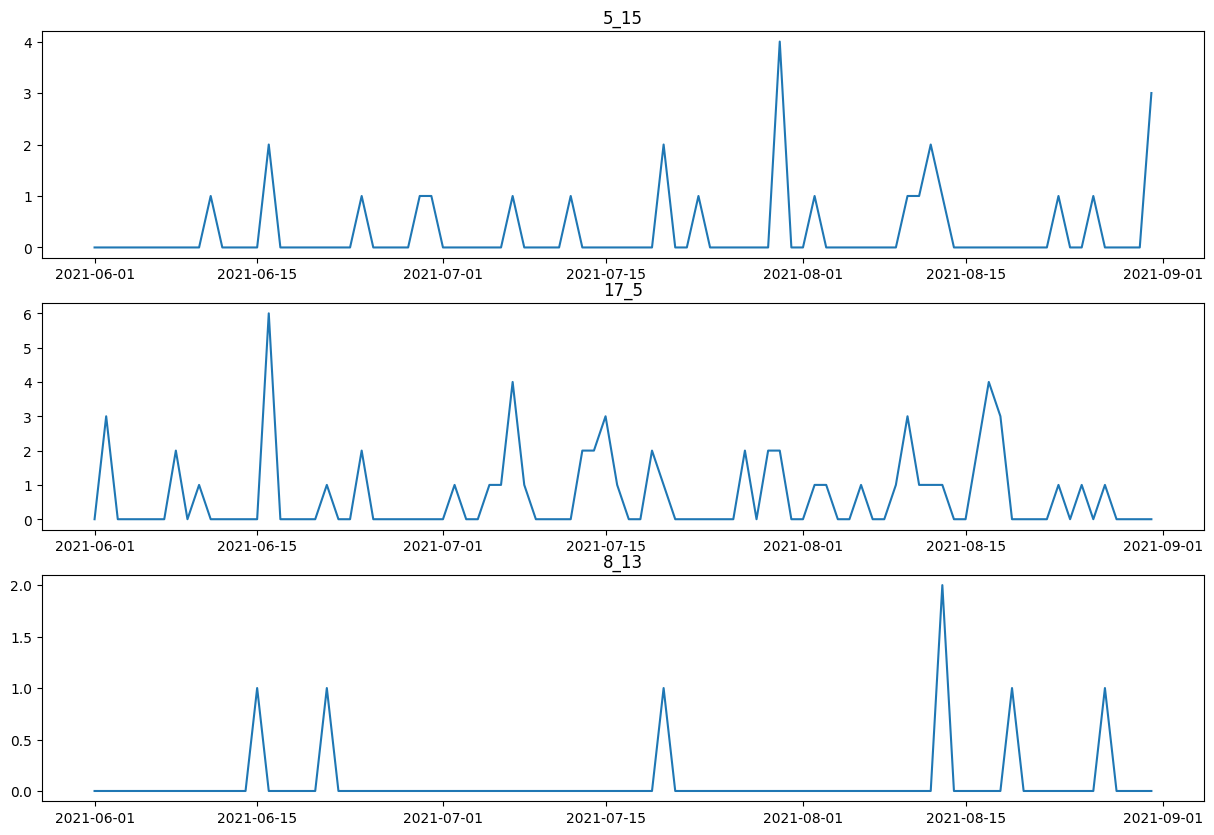

In [21]:
#### amostra de PAR OD para alguns pares

# amostra = random.sample(combinacoes_OD,3)
amostra = ['5_15', '17_5', '8_13']
fig, ax = plt.subplots(nrows=3, figsize = (15,10))

for _ in range(len(amostra)):
    ax[_].plot(series_ods.loc[series_ods["OD"]==amostra[_],'Data'], series_ods.loc[series_ods["OD"]==amostra[_],'Volume_OD'])
    ax[_].set_title(amostra[_])

# Modelagem

**Pontos importantes a serem considerados:**

* os parâmetros dos modelos serão os mesmos dos modelos dos volumes totais (serie historia de todos os dias, mais simples e sem diferenciacoes). Exemplo: Media móvel com 13 dias anteriores ou ARIMA com parametros (p,d,q) = (1,1,2)
* os erros calculados, que balizarão a escolha do melhor modelo, serão erros médios usando RMSE ou MAE para cada um dos 324 ODs, ou seja, média dos 324 erros
* nessa granularidade da análise a validacao visual dos modelos perde o sentido se tornando um componente de análise mais confuso
* Devido a alta granularidade poucos sao as series que tem muitos valores diferentes de zero, de forma que os dados serao arredondados para o inteiro mais proximo

## Media Movel

In [22]:
series_ods

,OD,Data,Volume_OD
0,1_1,2021-06-01,0
1,1_1,2021-06-02,0
2,1_1,2021-06-03,0
3,1_1,2021-06-04,0
4,1_1,2021-06-05,0
...,...,...,...
29803,33_33,2021-08-27,27
29804,33_33,2021-08-28,0
29805,33_33,2021-08-29,0
29806,33_33,2021-08-30,25


In [24]:
combinacoes_OD[:5]

['1_1', '1_5', '1_6', '1_8', '1_9']

#### Media Movel com step-by-step

In [ ]:
### modela com step by step e calcula erro

In [ ]:
for par in combinacoes_OD:
    par_od = series_ods.loc[series_ods["OD"] == par ]
    

In [27]:
pseries_ods

,OD,Data,Volume_OD
0,1_1,2021-06-01,0
1,1_1,2021-06-02,0
2,1_1,2021-06-03,0
3,1_1,2021-06-04,0
4,1_1,2021-06-05,0
...,...,...,...
29803,33_33,2021-08-27,27
29804,33_33,2021-08-28,0
29805,33_33,2021-08-29,0
29806,33_33,2021-08-30,25


In [176]:
series_ods_MA4 = series_ods.copy()

results_MA4 = list()
errors_324 = pd.DataFrame()

errors_RMSE = list()
errors_MAE = list()

for par in combinacoes_OD:

    # Seleciona uma das series do par OD
    par_od = series_ods_MA4.loc[series_ods_MA4["OD"] == par ]
    temp = list()

    # Executa o step-by-step
    for i in range(61, 93):
        X = par_od.iloc[:i]
        if i == 61:
            MA_base = X['Volume_OD'].rolling(4).mean().fillna(0)
            [temp.append(int(np.around(MA_base.values[i],0))) for i in range(len(MA_base))]
        else:
            MA_base = X['Volume_OD'].rolling(4).mean()
            temp.append(int(np.around(MA_base.values[-1],0)))

    ################################################################################################################

    # junta os erros de cada par OD do modelo
    errors_RMSE.append(mean_squared_error(X['Volume_OD'].values,temp, squared=False))
    errors_MAE.append( mean_absolute_error(X['Volume_OD'].values,temp))

    results_MA4.append(temp)

errors_324['OD'] = combinacoes_OD
errors_324['MA4_RMSE'] = errors_RMSE
errors_324['MA4_MAE'] = errors_MAE

# junta as previsoes no df com os volumes
series_ods_MA4 = pd.concat([series_ods_MA4,pd.Series(reduce(lambda xs, ys: xs + ys, results_MA4), name = 'MA4_pred')], axis = 1, ignore_index = True)
series_ods_MA4.columns = ['OD', 'Data', 'Volume_OD', 'MA4_pred']

series_ods_MA4

,OD,Data,Volume_OD,MA4_pred
0,1_1,2021-06-01,0,0
1,1_1,2021-06-02,0,0
2,1_1,2021-06-03,0,0
3,1_1,2021-06-04,0,0
4,1_1,2021-06-05,0,0
...,...,...,...,...
29803,33_33,2021-08-27,27,24
29804,33_33,2021-08-28,0,19
29805,33_33,2021-08-29,0,14
29806,33_33,2021-08-30,25,13


In [177]:
errors_324

,OD,MA4_RMSE,MA4_MAE
0,1_1,0.208514,0.043478
1,1_5,1.507229,1.141304
2,1_6,1.179536,0.869565
3,1_8,0.000000,0.000000
4,1_9,0.989071,0.652174
...,...,...,...
319,33_23,0.208514,0.043478
320,33_26,0.000000,0.000000
321,33_31,0.714751,0.402174
322,33_32,0.820922,0.456522


In [162]:
for par in combinacoes_OD[316:324]:
    display(series_ods_.loc[series_ods_["OD"] == par ])
    

,OD,Data,Volume_OD,MA4_pred
29072,33_20,2021-06-01,0,0
29073,33_20,2021-06-02,0,0
29074,33_20,2021-06-03,0,0
29075,33_20,2021-06-04,0,0
29076,33_20,2021-06-05,0,0
...,...,...,...,...
29159,33_20,2021-08-27,0,0
29160,33_20,2021-08-28,0,0
29161,33_20,2021-08-29,0,0
29162,33_20,2021-08-30,0,0


,OD,Data,Volume_OD,MA4_pred
29164,33_21,2021-06-01,0,0
29165,33_21,2021-06-02,0,0
29166,33_21,2021-06-03,0,0
29167,33_21,2021-06-04,0,0
29168,33_21,2021-06-05,0,0
...,...,...,...,...
29251,33_21,2021-08-27,0,0
29252,33_21,2021-08-28,0,0
29253,33_21,2021-08-29,0,0
29254,33_21,2021-08-30,0,0


,OD,Data,Volume_OD,MA4_pred
29256,33_22,2021-06-01,1,0
29257,33_22,2021-06-02,0,0
29258,33_22,2021-06-03,0,0
29259,33_22,2021-06-04,0,0
29260,33_22,2021-06-05,0,0
...,...,...,...,...
29343,33_22,2021-08-27,0,0
29344,33_22,2021-08-28,0,0
29345,33_22,2021-08-29,0,0
29346,33_22,2021-08-30,0,0


,OD,Data,Volume_OD,MA4_pred
29348,33_23,2021-06-01,0,0
29349,33_23,2021-06-02,1,0
29350,33_23,2021-06-03,0,0
29351,33_23,2021-06-04,0,0
29352,33_23,2021-06-05,0,0
...,...,...,...,...
29435,33_23,2021-08-27,0,0
29436,33_23,2021-08-28,0,0
29437,33_23,2021-08-29,0,0
29438,33_23,2021-08-30,0,0


,OD,Data,Volume_OD,MA4_pred
29440,33_26,2021-06-01,0,0
29441,33_26,2021-06-02,0,0
29442,33_26,2021-06-03,0,0
29443,33_26,2021-06-04,0,0
29444,33_26,2021-06-05,0,0
...,...,...,...,...
29527,33_26,2021-08-27,0,0
29528,33_26,2021-08-28,0,0
29529,33_26,2021-08-29,0,0
29530,33_26,2021-08-30,0,0


,OD,Data,Volume_OD,MA4_pred
29532,33_31,2021-06-01,0,0
29533,33_31,2021-06-02,3,0
29534,33_31,2021-06-03,0,0
29535,33_31,2021-06-04,0,1
29536,33_31,2021-06-05,0,1
...,...,...,...,...
29619,33_31,2021-08-27,1,0
29620,33_31,2021-08-28,0,0
29621,33_31,2021-08-29,0,0
29622,33_31,2021-08-30,0,0


,OD,Data,Volume_OD,MA4_pred
29624,33_32,2021-06-01,0,0
29625,33_32,2021-06-02,0,0
29626,33_32,2021-06-03,0,0
29627,33_32,2021-06-04,0,0
29628,33_32,2021-06-05,0,0
...,...,...,...,...
29711,33_32,2021-08-27,0,2
29712,33_32,2021-08-28,0,1
29713,33_32,2021-08-29,0,0
29714,33_32,2021-08-30,1,0


,OD,Data,Volume_OD,MA4_pred
29716,33_33,2021-06-01,25,0
29717,33_33,2021-06-02,29,0
29718,33_33,2021-06-03,0,0
29719,33_33,2021-06-04,0,14
29720,33_33,2021-06-05,0,7
...,...,...,...,...
29803,33_33,2021-08-27,27,24
29804,33_33,2021-08-28,0,19
29805,33_33,2021-08-29,0,14
29806,33_33,2021-08-30,25,13


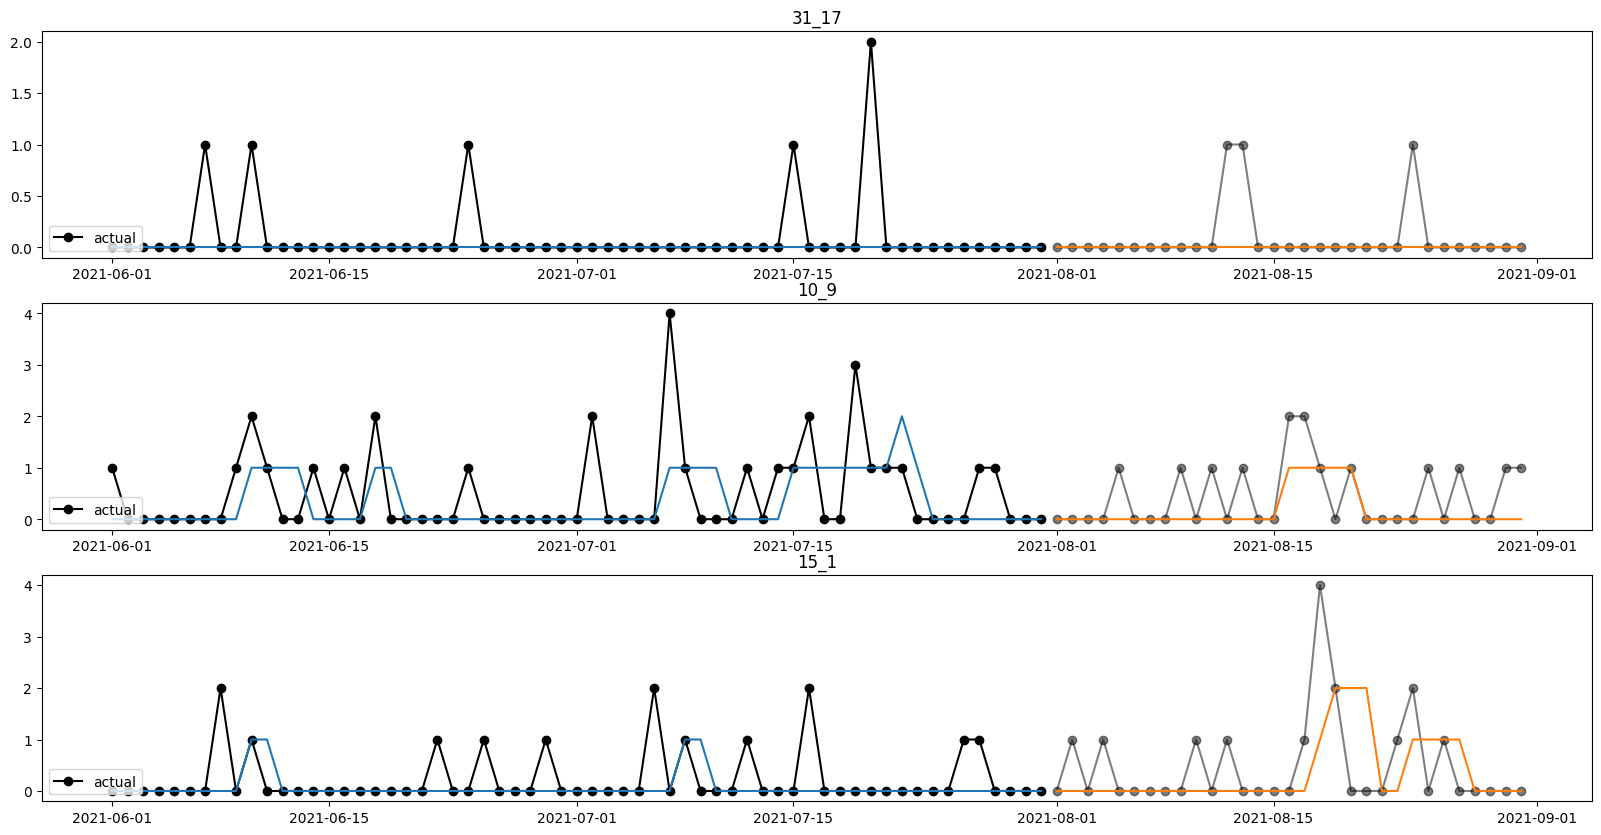

In [180]:
#### amostra de PAR OD para alguns pares

amostra = random.sample(combinacoes_OD,3)
# amostra = ['5_15', '17_5', '8_4'] # '10_32'
fig, ax = plt.subplots(nrows=3, figsize = (20,10))

for aaa in range(len(amostra)):
    ax[aaa].plot(series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Data'][:61], series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Volume_OD'][:61], marker="o", color="black")
    ax[aaa].plot(series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Data'][61:], series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Volume_OD'][61:], marker="o", color="black", alpha = 0.5)
    ax[aaa].plot(series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Data'][:61], series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'MA4_pred'][:61], )
    ax[aaa].plot(series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'Data'][61:], series_ods_MA4.loc[series_ods_MA4["OD"]==amostra[aaa],'MA4_pred'][61:], )

    ax[aaa].set_title(amostra[aaa])
    ax[aaa].legend(loc = 'lower left', labels = ['actual'])



## Suavizacao Exponencial


In [184]:
series_ods_SES = series_ods.copy()

results_SES = list()

errors_RMSE = list()
errors_MAE = list()

for par in combinacoes_OD:

    # Seleciona uma das series do par OD
    par_od = series_ods_SES.loc[series_ods_SES["OD"] == par ]
    temp = list()

    # Executa o step-by-step
    for i in range(61, 93):
        X = par_od.iloc[:i]
        if i == 61:
            SES_base = SimpleExpSmoothing(X['Volume_OD'].values, initialization_method="estimated").fit()
            [temp.append(int(np.around(SES_base.fittedvalues[i],0))) for i in range(len(SES_base.fittedvalues))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            SES_base = SimpleExpSmoothing(X['Volume_OD'].values, initialization_method="estimated").fit(smoothing_level=SES_base.model.params["smoothing_level"])
            temp.append(int(np.around(SES_base.fittedvalues[-1],0)))

    ################################################################################################################

    # junta os erros de cada par OD do modelo
    errors_RMSE.append(mean_squared_error(X['Volume_OD'].values,temp, squared=False))
    errors_MAE.append( mean_absolute_error(X['Volume_OD'].values,temp))

    results_SES.append(temp)

errors_324['OD'] = combinacoes_OD
errors_324['SES_RMSE'] = errors_RMSE
errors_324['SES_MAE'] = errors_MAE

# junta as previsoes no df com os volumes
series_ods_SES = pd.concat([series_ods_SES,pd.Series(reduce(lambda xs, ys: xs + ys, results_SES), name = 'SES_pred')], axis = 1, ignore_index = True)
series_ods_SES.columns = ['OD', 'Data', 'Volume_OD', 'SES_pred']

series_ods_SES

,OD,Data,Volume_OD,SES_pred
0,1_1,2021-06-01,0,0
1,1_1,2021-06-02,0,0
2,1_1,2021-06-03,0,0
3,1_1,2021-06-04,0,0
4,1_1,2021-06-05,0,0
...,...,...,...,...
29803,33_33,2021-08-27,27,13
29804,33_33,2021-08-28,0,13
29805,33_33,2021-08-29,0,13
29806,33_33,2021-08-30,25,13


In [186]:
errors_324

,OD,MA4_RMSE,MA4_MAE,SES_RMSE,SES_MAE
0,1_1,0.208514,0.043478,0.208514,0.043478
1,1_5,1.507229,1.141304,1.563858,1.206522
2,1_6,1.179536,0.869565,1.202353,0.945652
3,1_8,0.000000,0.000000,0.000000,0.000000
4,1_9,0.989071,0.652174,1.058095,0.619565
...,...,...,...,...,...
319,33_23,0.208514,0.043478,0.208514,0.043478
320,33_26,0.000000,0.000000,0.000000,0.000000
321,33_31,0.714751,0.402174,0.793999,0.369565
322,33_32,0.820922,0.456522,0.989071,0.478261


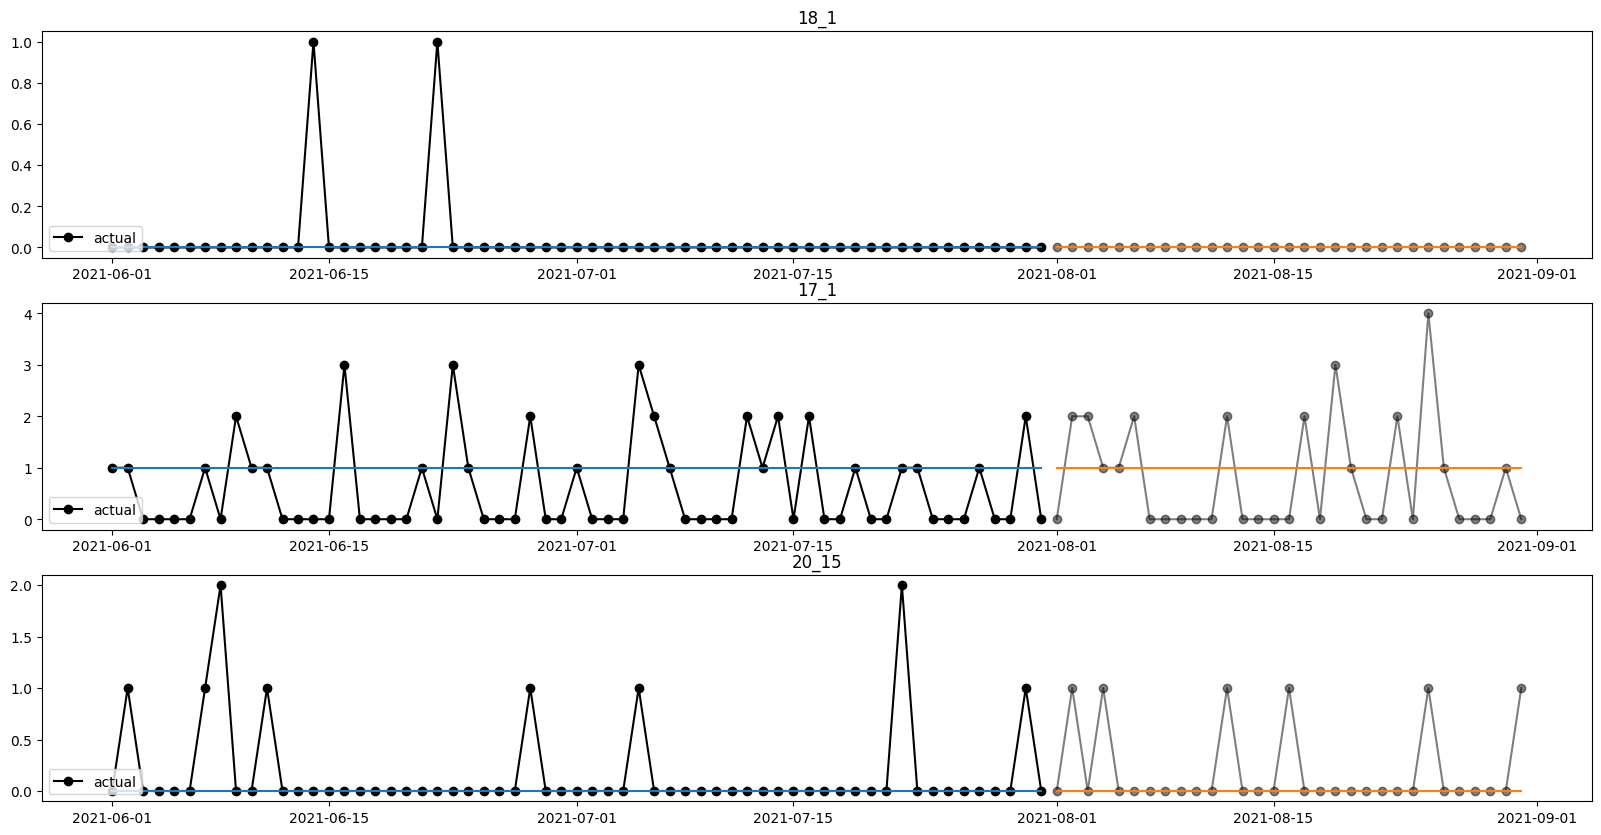

In [185]:
#### amostra de PAR OD para alguns pares

amostra = random.sample(combinacoes_OD,3)
# amostra = ['5_15', '17_5', '8_4'] # '10_32'
fig, ax = plt.subplots(nrows=3, figsize = (20,10))

for aaa in range(len(amostra)):
    ax[aaa].plot(series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Data'][:61], series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Volume_OD'][:61], marker="o", color="black")
    ax[aaa].plot(series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Data'][61:], series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Volume_OD'][61:], marker="o", color="black", alpha = 0.5)
    ax[aaa].plot(series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Data'][:61], series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'SES_pred'][:61], )
    ax[aaa].plot(series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'Data'][61:], series_ods_SES.loc[series_ods_SES["OD"]==amostra[aaa],'SES_pred'][61:], )

    ax[aaa].set_title(amostra[aaa])
    ax[aaa].legend(loc = 'lower left', labels = ['actual'])



## Metodo de Holt

In [187]:
series_ods_SEH = series_ods.copy()

results_SEH = list()

errors_RMSE = list()
errors_MAE = list()

for par in combinacoes_OD:

    # Seleciona uma das series do par OD
    par_od = series_ods_SEH.loc[series_ods_SEH["OD"] == par ]
    temp = list()

    # Executa o step-by-step
    for i in range(61, 93):
        X = par_od.iloc[:i]
        if i == 61:
            SEH_base = Holt(X['Volume_OD'].values, damped_trend= True,initialization_method="estimated").fit()
            [temp.append(int(np.around(SEH_base.fittedvalues[i],0))) for i in range(len(SEH_base.fittedvalues))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            SEH_base = Holt(X['Volume_OD'].values, damped_trend= True, initialization_method="estimated").fit(  smoothing_level = SEH_base.model.params["smoothing_level"],
                                                                                                                smoothing_trend = SEH_base.model.params["smoothing_trend"]  )
            temp.append(int(np.around(SEH_base.fittedvalues[-1],0)))

    ################################################################################################################

    # junta os erros de cada par OD do modelo
    errors_RMSE.append(mean_squared_error(X['Volume_OD'].values,temp, squared=False))
    errors_MAE.append( mean_absolute_error(X['Volume_OD'].values,temp))

    results_SEH.append(temp)

errors_324['OD'] = combinacoes_OD
errors_324['SEH_RMSE'] = errors_RMSE
errors_324['SEH_MAE'] = errors_MAE

# junta as previsoes no df com os volumes
series_ods_SEH = pd.concat([series_ods_SEH,pd.Series(reduce(lambda xs, ys: xs + ys, results_SEH), name = 'SEH_pred')], axis = 1, ignore_index = True)
series_ods_SEH.columns = ['OD', 'Data', 'Volume_OD', 'SEH_pred']

series_ods_SEH

,OD,Data,Volume_OD,SEH_pred
0,1_1,2021-06-01,0,0
1,1_1,2021-06-02,0,0
2,1_1,2021-06-03,0,0
3,1_1,2021-06-04,0,0
4,1_1,2021-06-05,0,0
...,...,...,...,...
29803,33_33,2021-08-27,27,27
29804,33_33,2021-08-28,0,27
29805,33_33,2021-08-29,0,5
29806,33_33,2021-08-30,25,1


In [188]:
errors_324

,OD,MA4_RMSE,MA4_MAE,SES_RMSE,SES_MAE,SEH_RMSE,SEH_MAE
0,1_1,0.208514,0.043478,0.208514,0.043478,0.208514,0.043478
1,1_5,1.507229,1.141304,1.563858,1.206522,1.587998,1.239130
2,1_6,1.179536,0.869565,1.202353,0.945652,1.202353,0.945652
3,1_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1_9,0.989071,0.652174,1.058095,0.619565,1.042572,0.760870
...,...,...,...,...,...,...,...
319,33_23,0.208514,0.043478,0.208514,0.043478,0.208514,0.043478
320,33_26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
321,33_31,0.714751,0.402174,0.793999,0.369565,0.820922,0.478261
322,33_32,0.820922,0.456522,0.989071,0.478261,1.063219,0.695652


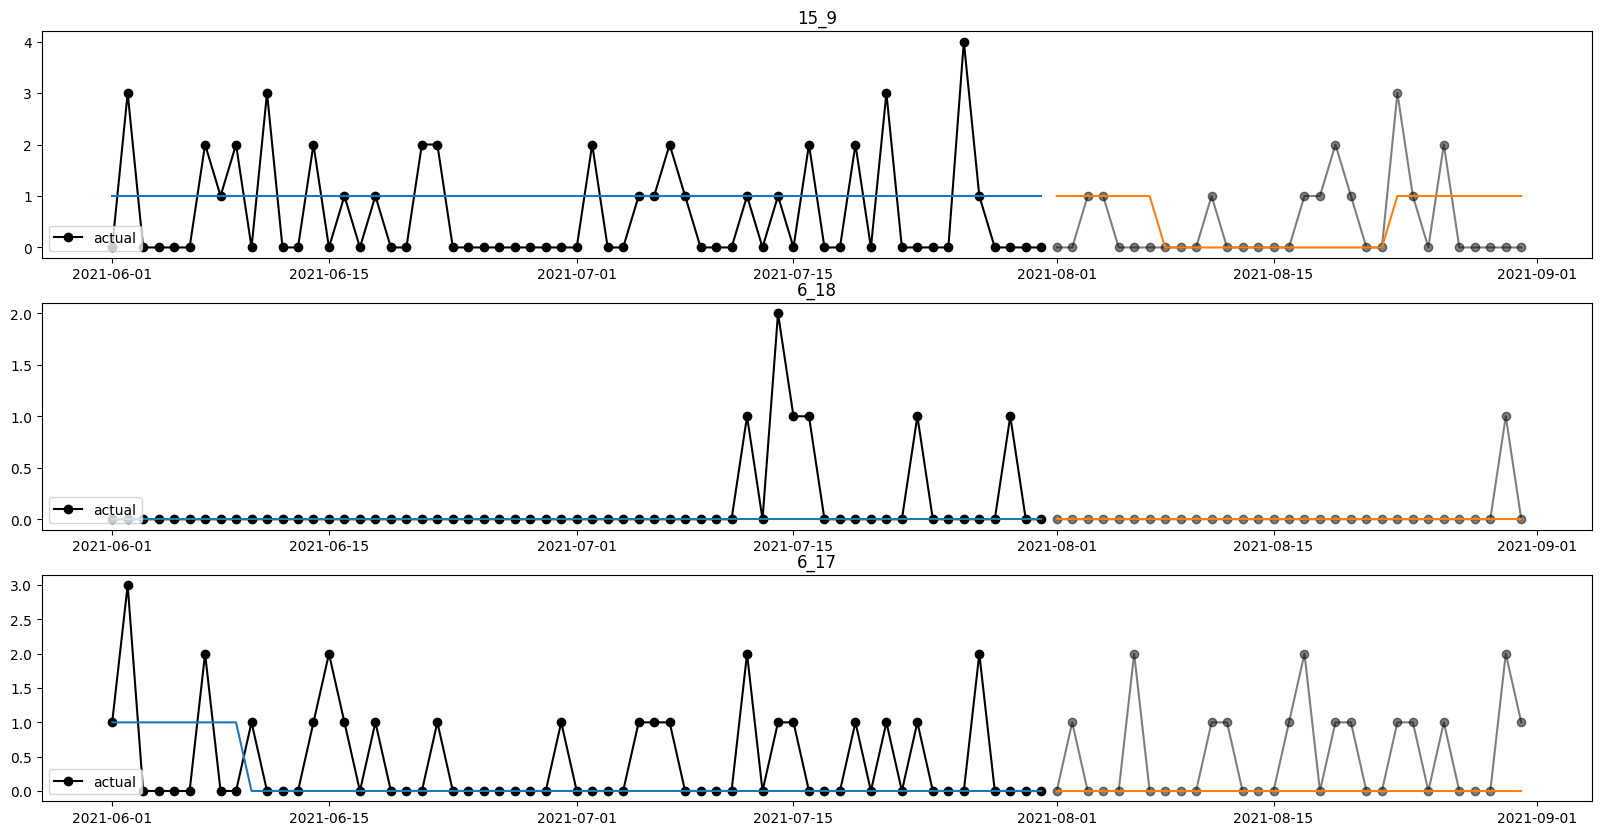

In [192]:
#### amostra de PAR OD para alguns pares

amostra = random.sample(combinacoes_OD,3)
# amostra = ['5_15', '17_5', '8_4'] # '10_32'
fig, ax = plt.subplots(nrows=3, figsize = (20,10))

for aaa in range(len(amostra)):
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][:61], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Volume_OD'][:61], marker="o", color="black")
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][61:], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Volume_OD'][61:], marker="o", color="black", alpha = 0.5)
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][:61], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'SEH_pred'][:61], )
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][61:], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'SEH_pred'][61:], )

    ax[aaa].set_title(amostra[aaa])
    ax[aaa].legend(loc = 'lower left', labels = ['actual'])



## Metodo de Holt Winters

In [195]:
series_ods_WH = series_ods.copy()

results_WH = list()

errors_RMSE = list()
errors_MAE = list()

for par in combinacoes_OD:

    # Seleciona uma das series do par OD
    par_od = series_ods_WH.loc[series_ods_WH["OD"] == par ]
    temp = list()

    # Executa o step-by-step
    for i in range(61, 93):
        X = par_od.iloc[:i]
        if i == 61:
            WH_base = ExponentialSmoothing( X['Volume_OD'].values,
                                            seasonal_periods=2,
                                            trend="add",
                                            seasonal="mul",
                                            damped_trend=True,
                                            use_boxcox=True,
                                            initialization_method="estimated").fit()
            [temp.append(int(np.around(WH_base.fittedvalues[i],0))) for i in range(len(WH_base.fittedvalues))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            WH_base = ExponentialSmoothing( X['Volume_OD'].values,
                                            seasonal_periods=2,
                                            trend="add",
                                            seasonal="mul",
                                            damped_trend=True,
                                            use_boxcox=True,
                                            initialization_method="estimated").fit( smoothing_level = WH_base.model.params["smoothing_level"],
                                                                                    smoothing_trend = WH_base.model.params["smoothing_trend"],
                                                                                    optimized = True  )
            temp.append(int(np.around(WH_base.fittedvalues[-1],0)))

################################################################################################################

    # junta os erros de cada par OD do modelo
    errors_RMSE.append(mean_squared_error(X['Volume_OD'].values,temp, squared=False))
    errors_MAE.append( mean_absolute_error(X['Volume_OD'].values,temp))

    results_WH.append(temp)

errors_324['OD'] = combinacoes_OD
errors_324['WH_RMSE'] = errors_RMSE
errors_324['WH_MAE'] = errors_MAE

# junta as previsoes no df com os volumes
series_ods_WH = pd.concat([series_ods_WH,pd.Series(reduce(lambda xs, ys: xs + ys, results_WH), name = 'WH_pred')], axis = 1, ignore_index = True)
series_ods_WH.columns = ['OD', 'Data', 'Volume_OD', 'WH_pred']

series_ods_WH

1_1


ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.

In [ ]:
errors_324

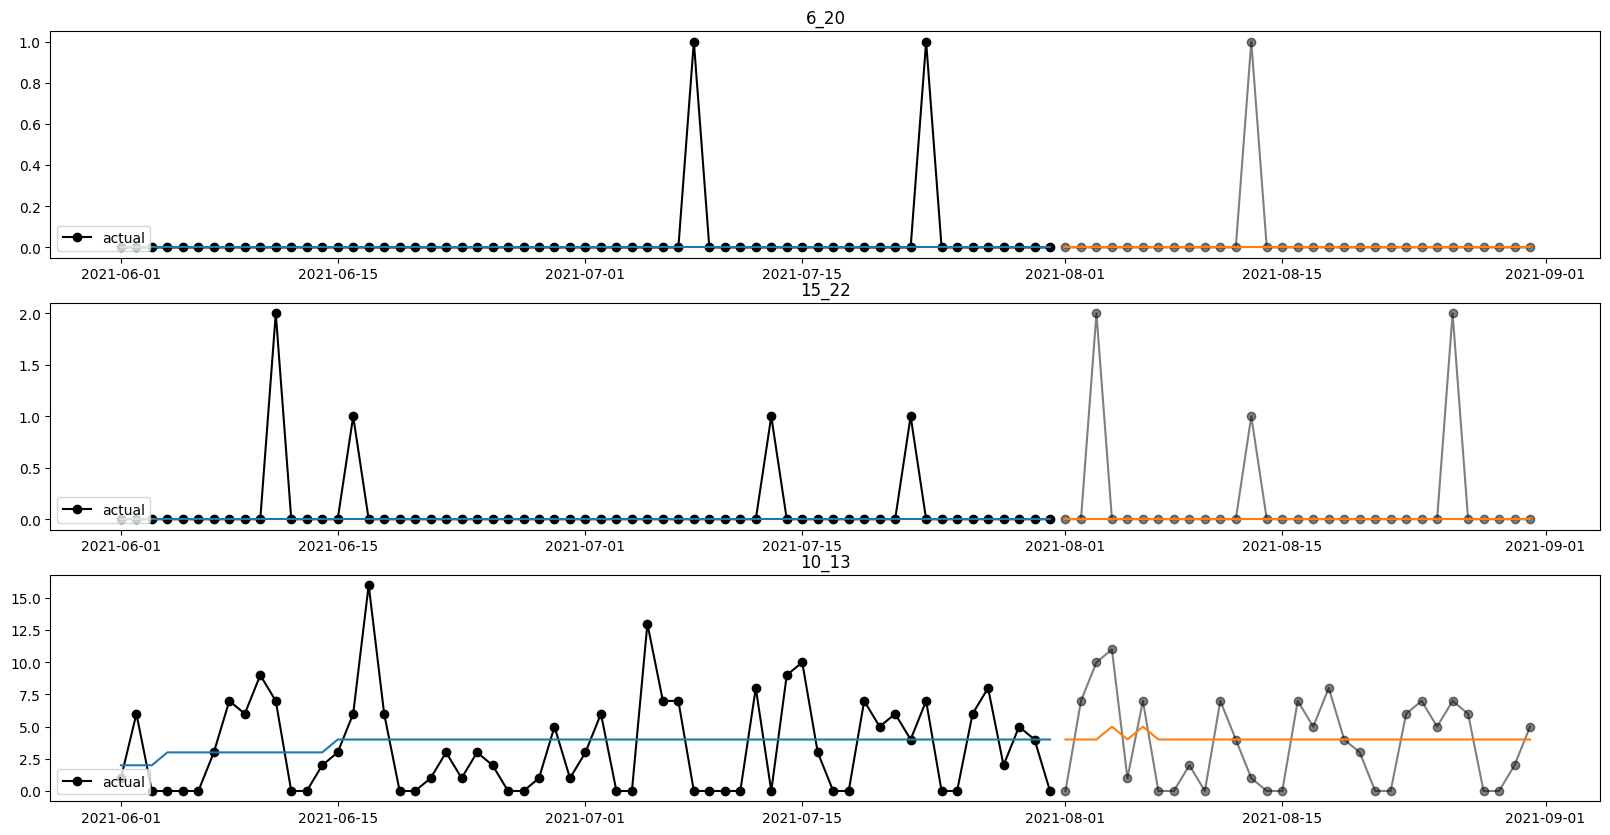

In [194]:
#### amostra de PAR OD para alguns pares

amostra = random.sample(combinacoes_OD,3)
# amostra = ['5_15', '17_5', '8_4'] # '10_32'
fig, ax = plt.subplots(nrows=3, figsize = (20,10))

for aaa in range(len(amostra)):
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][:61], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Volume_OD'][:61], marker="o", color="black")
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][61:], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Volume_OD'][61:], marker="o", color="black", alpha = 0.5)
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][:61], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'SEH_pred'][:61], )
    ax[aaa].plot(series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'Data'][61:], series_ods_SEH.loc[series_ods_SEH["OD"]==amostra[aaa],'SEH_pred'][61:], )

    ax[aaa].set_title(amostra[aaa])
    ax[aaa].legend(loc = 'lower left', labels = ['actual'])



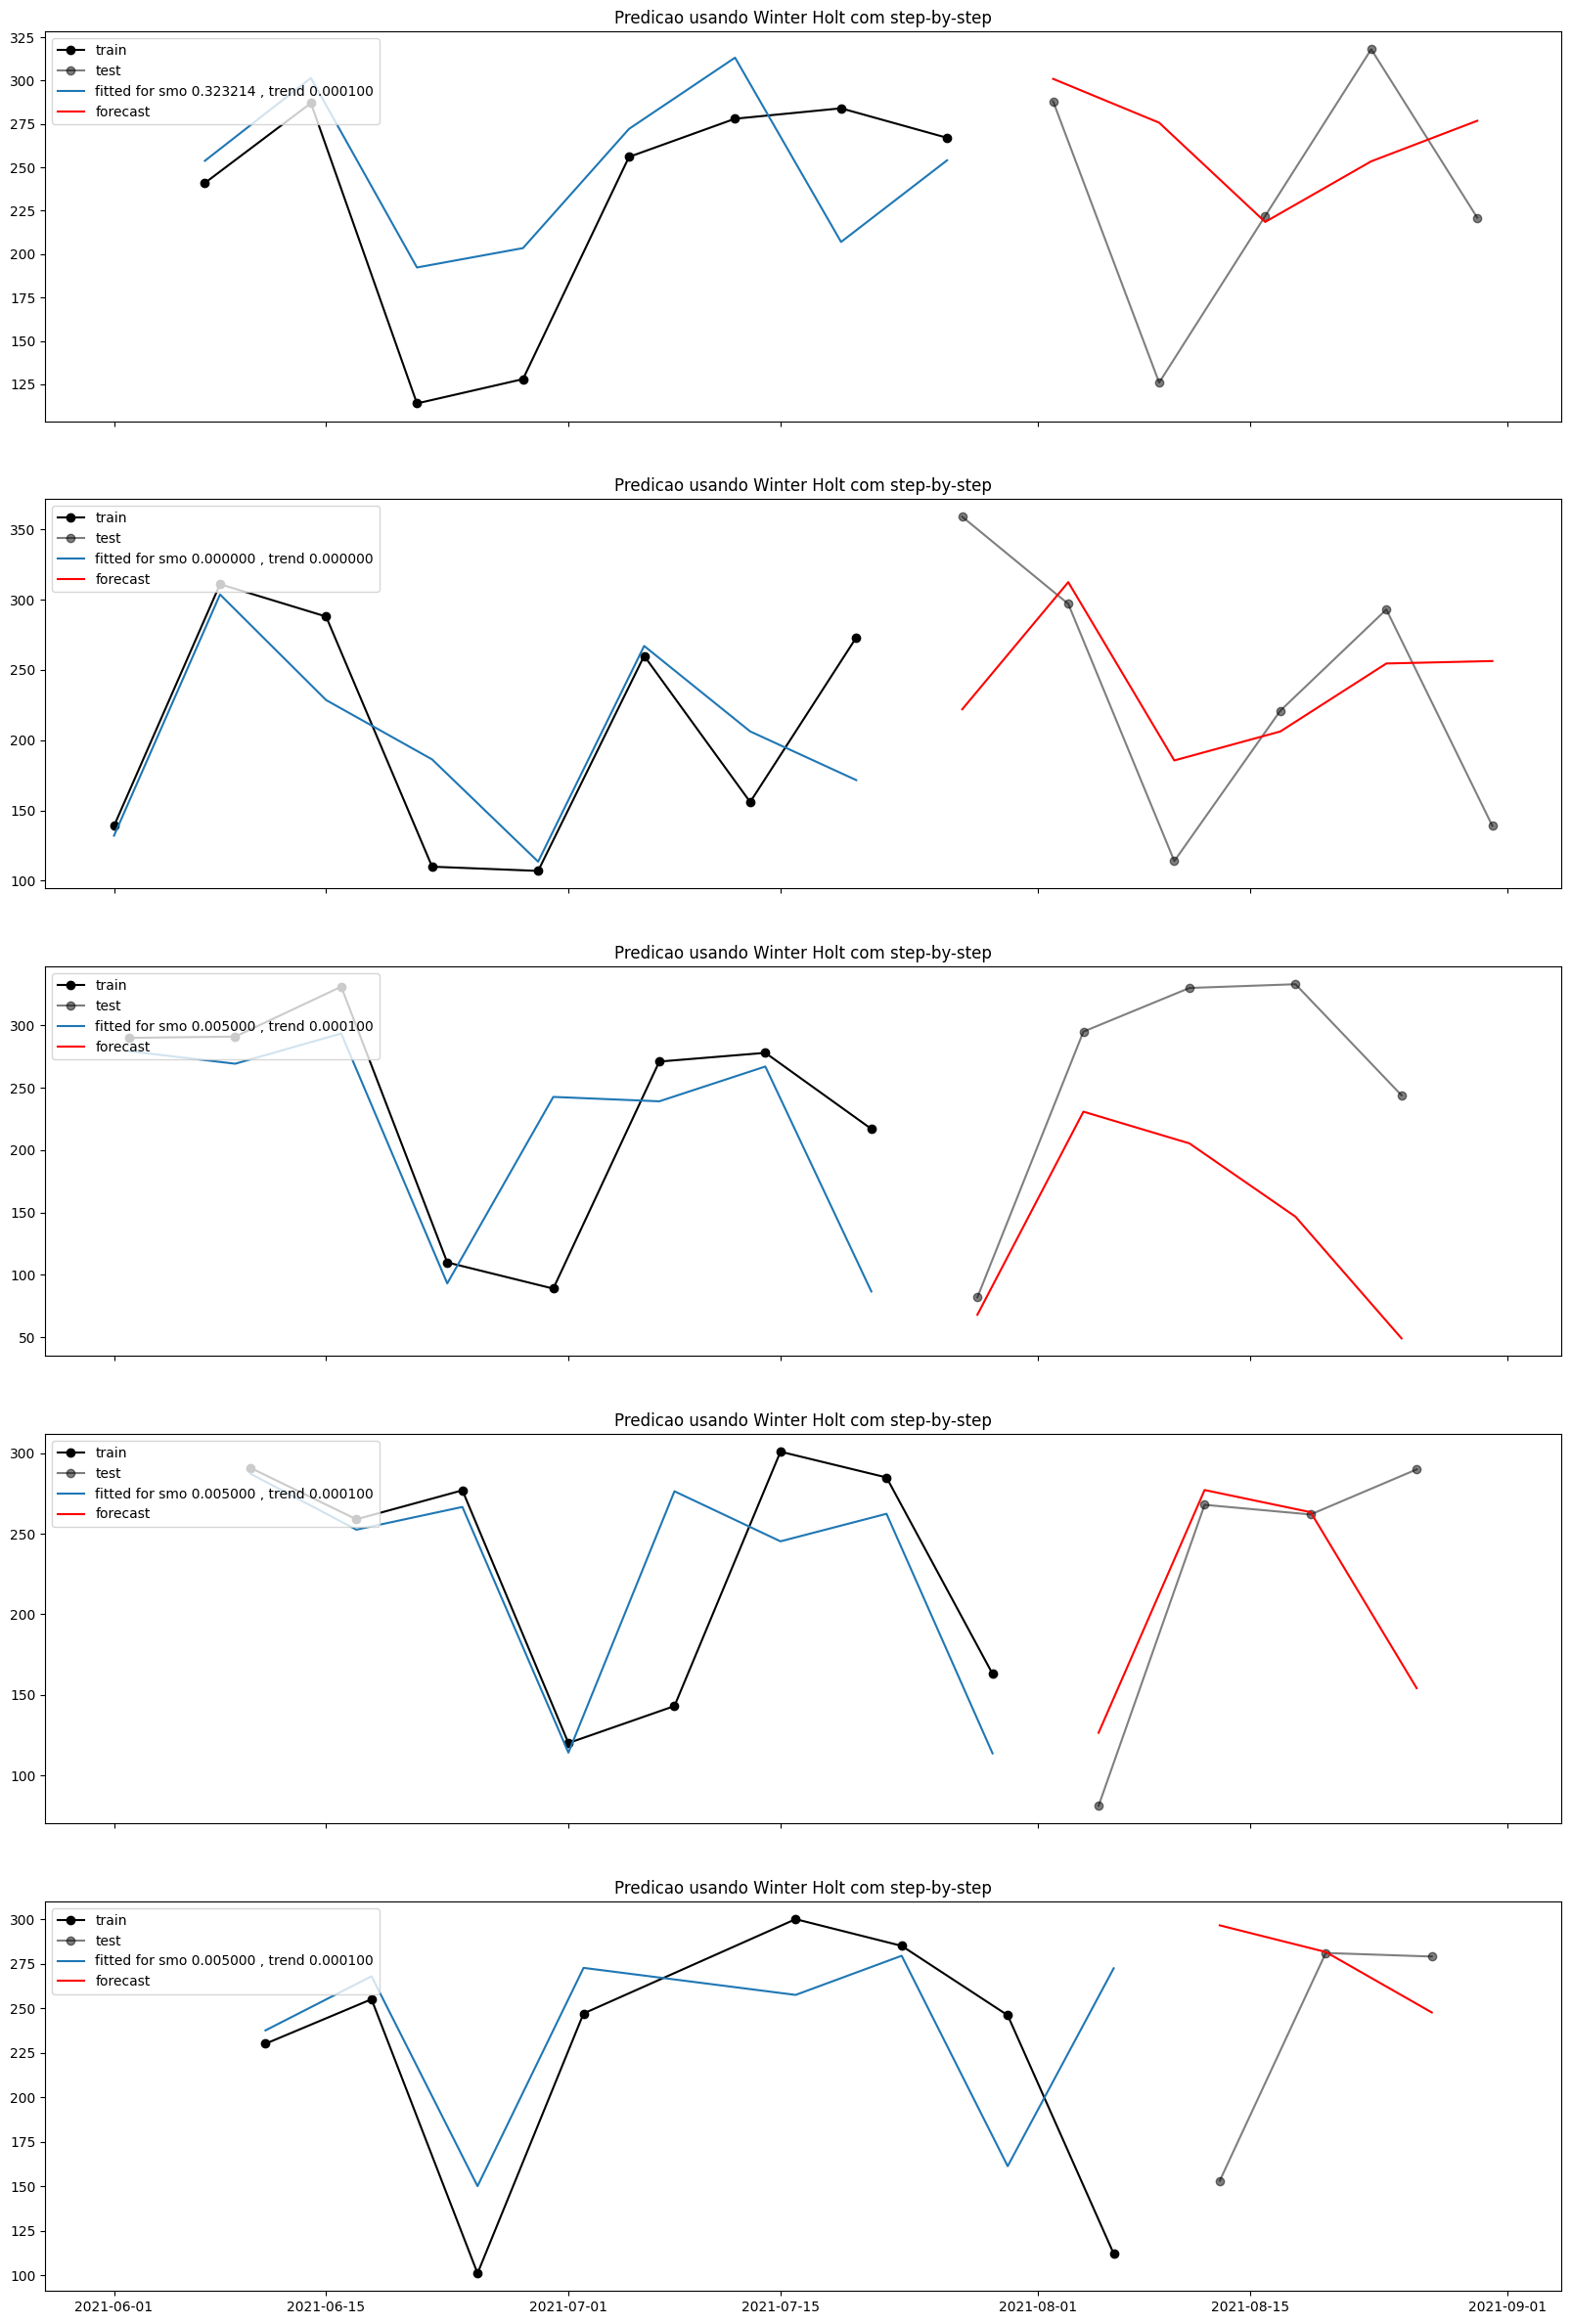

In [ ]:
fig, ax = plt.subplots(nrows=5,figsize=(20,30), sharex= True)

segundas_WH =   segundas.iloc[:,:3] .copy()
tercas_WH =     tercas  .iloc[:,:3] .copy()
quartas_WH =    quartas .iloc[:,:3] .copy()
quintas_WH =    quintas .iloc[:,:3] .copy()
sextas_WH =     sextas  .iloc[:,:3] .copy()

dfs_WH = [segundas_WH, tercas_WH, quartas_WH, quintas_WH, sextas_WH]

for idx, df in enumerate(dfs_WH):

    results = list()
    df_results_WH = pd.DataFrame()

    for i in range(8, df.shape[0]+1):
        
        X = df.iloc[:i]

        ### primeiro adiciona aos resultados os valores de treinamento
        ### Esse passo tambem determina o parameto de suavizacao para o step by step
        if i == 8:
            if idx == 0:
                WH_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="add",
                                                                        use_boxcox=True,initialization_method="estimated").fit()

            elif (idx == 1) | (idx == 2) | (idx == 3):
                WH_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,
                                                                        use_boxcox=True,initialization_method="estimated").fit()

            elif idx == 4:
                WH_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="add",damped_trend=True,
                                                                        use_boxcox=True,initialization_method="estimated").fit()

            [results.append(WH_base.fittedvalues[i]) for i in range(len(WH_base.fittedvalues))]

        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            if idx == 0:
                WH_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="add",use_boxcox=True,
                                                initialization_method="estimated").fit( smoothing_level=WH_base.model.params["smoothing_level"],
                                                                                        smoothing_trend=WH_base.model.params["smoothing_trend"], 
                                                                                        smoothing_seasonal=WH_base.model.params["smoothing_seasonal"], 
                                                                                        damping_trend=WH_base.model.params["damping_trend"])

            elif (idx == 1) | (idx == 2) | (idx == 3):
                WH_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,
                                                initialization_method="estimated").fit( smoothing_level=WH_base.model.params["smoothing_level"],
                                                                                        smoothing_trend=WH_base.model.params["smoothing_trend"], 
                                                                                        smoothing_seasonal=WH_base.model.params["smoothing_seasonal"], 
                                                                                        damping_trend=WH_base.model.params["damping_trend"])


            elif idx == 4:
                WH_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="add",damped_trend=True,use_boxcox=True,
                                                initialization_method="estimated").fit( smoothing_level=WH_base.model.params["smoothing_level"],
                                                                                        smoothing_trend=WH_base.model.params["smoothing_trend"], 
                                                                                        smoothing_seasonal=WH_base.model.params["smoothing_seasonal"], 
                                                                                        damping_trend=WH_base.model.params["damping_trend"])
            results.append(WH_base.fittedvalues[-1])


    df = pd.concat([df,pd.Series(results, name = 'H')], axis = 1, ignore_index = True)
    df.columns = ['DOW', 'Data', 'y_true', 'y_pred']
    dfs_WH[idx] = df.copy()

    ax[idx].plot(df['Data'][:8],df['y_true'][:8], marker="o", color="black")
    ax[idx].plot(df['Data'][8:],df['y_true'][8:], marker="o", color="black", alpha = 0.5)

    ax[idx].plot(df['Data'][:8],df['y_pred'][:8])

    ax[idx].plot(df['Data'][8:],df['y_pred'][8:], color= 'red')


    ax[idx].set_title('Predicao usando Winter Holt com step-by-step')
    ax[idx].legend(loc = 'upper left', labels = ['train', 'test',
                    'fitted for smo {:f} , trend {:f}'.format(WH_base.model.params["smoothing_level"], WH_base.model.params["smoothing_trend"]),
                    'forecast'])

plt.show();


### calculo do erro

In [ ]:
print('DF0 = Segundas')
print('DF1 = Tercas')
print('DF2 = Quartas')
print('DF3 = Quintas')
print('DF4 = Sextas')
print()
print()

for idx, df in enumerate(dfs_WH):
    print('=================================================', 'errors day_of_week',idx,'=================================================')

    print('\t erro (RMSE) da previsao \t',
            mean_squared_error( dfs_WH[idx]['y_true'][8:],
                                dfs_WH[idx]['y_pred'][8:],
                                squared=False))


DF0 = Segundas
DF1 = Tercas
DF2 = Quartas
DF3 = Quintas
DF4 = Sextas


================================================= errors day_of_week 0 =================================================
	 erro (RMSE) da previsao 	 77.2946282202461
================================================= errors day_of_week 1 =================================================
	 erro (RMSE) da previsao 	 81.23404071315346
================================================= errors day_of_week 2 =================================================
	 erro (RMSE) da previsao 	 136.0461632536847
================================================= errors day_of_week 3 =================================================
	 erro (RMSE) da previsao 	 71.788324801443
================================================= errors day_of_week 4 =================================================
	 erro (RMSE) da previsao 	 84.82819870750104


## ARIMA


### Determinação dos parâmetros do ARIMA

#### Checar se a série é estacionária
A série estacionária é condição _sine qua non_ para a aplicação do método; caso nao for, é possível utilizar a diferenciação da série - quantas vezes forem necessárias -  para torná-la estacionária. Escolhido o radar, observa-se se a série pode ser considerada estacionária (p-value inferior a 0.05) por meio do teste de Dickey-Fuller aumentado (ADF).

In [ ]:
segundas_ARIMA =   segundas.iloc[:,:3] .copy()
tercas_ARIMA =     tercas  .iloc[:,:3] .copy()
quartas_ARIMA =    quartas .iloc[:,:3] .copy()
quintas_ARIMA =    quintas .iloc[:,:3] .copy()
sextas_ARIMA =     sextas  .iloc[:,:3] .copy()

dfs_ARIMA = [segundas_ARIMA, tercas_ARIMA, quartas_ARIMA, quintas_ARIMA, sextas_ARIMA]


for idx, df in enumerate(dfs_ARIMA):

    print('=================================================', 'adfuller day_of_week',idx,'=================================================')

    result_adfuller = adfuller(df.Volume)
    print('ADF Statistic: %f' % result_adfuller[0])
    print('p-value: %f' % result_adfuller[1])

================================================= adfuller day_of_week 0 =================================================
ADF Statistic: -2.671017
p-value: 0.079189
================================================= adfuller day_of_week 1 =================================================
ADF Statistic: -2.656224
p-value: 0.081925
================================================= adfuller day_of_week 2 =================================================
ADF Statistic: 1.377425
p-value: 0.997009
================================================= adfuller day_of_week 3 =================================================
ADF Statistic: -0.112935
p-value: 0.948135
================================================= adfuller day_of_week 4 =================================================
ADF Statistic: -3.193874
p-value: 0.020342


#### Validação Visual

Para validar visualmente o resultado do teste ADF, plotamos funções de autocorrelação para a série original, com diferenciação de primeira e de segunda ordem. 

Espera-se que a série original tenha uma curva da Função de Autocorrelação (ACF) decrescente enquanto as outras possuam uma queda abrupta pois, segundo o teste ADF, elas já serão diferenciadas.

==================================================== ACF day_of_week 0 ====================================================


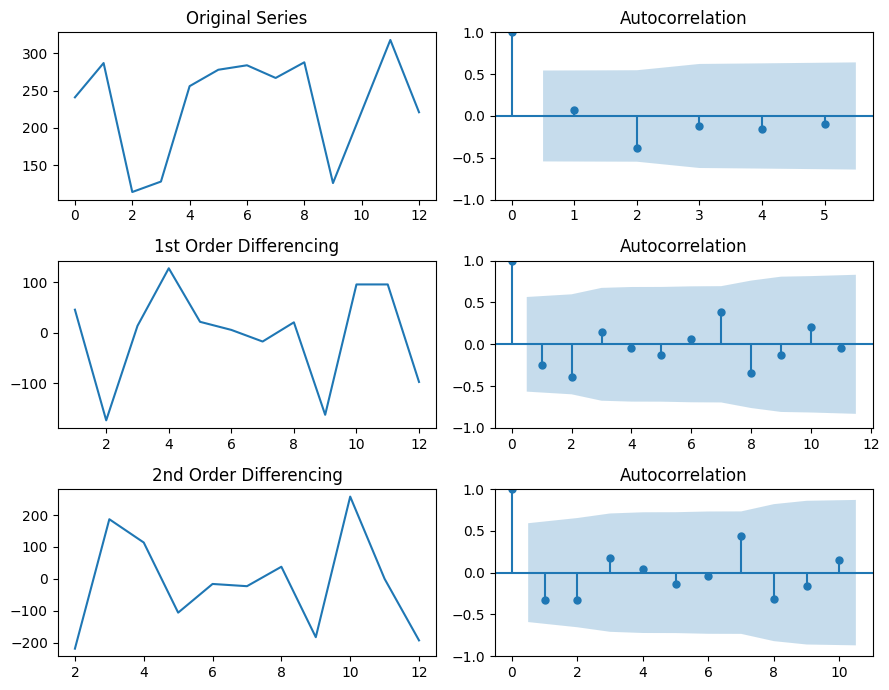

==================================================== ACF day_of_week 1 ====================================================


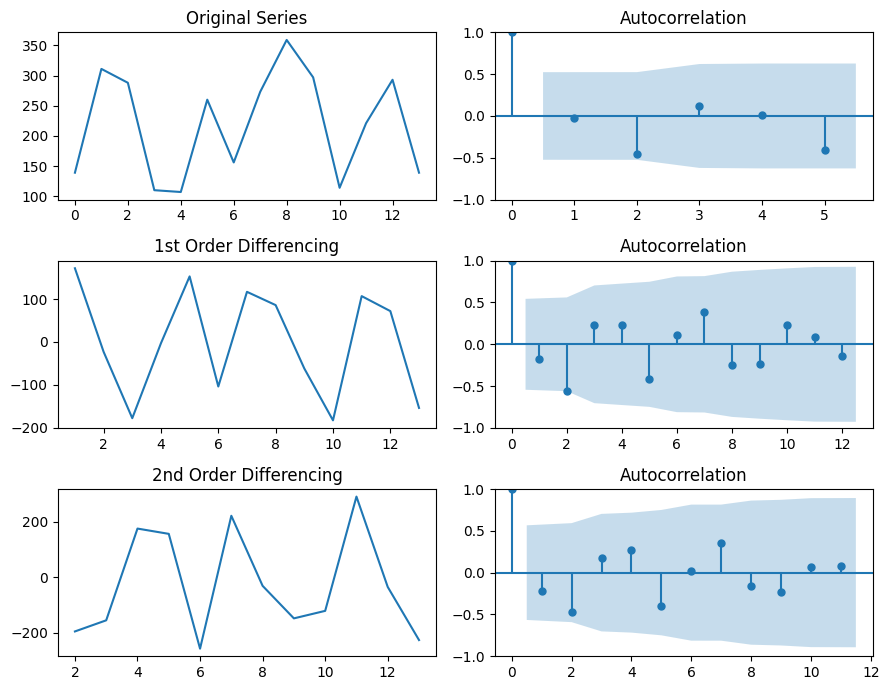

==================================================== ACF day_of_week 2 ====================================================


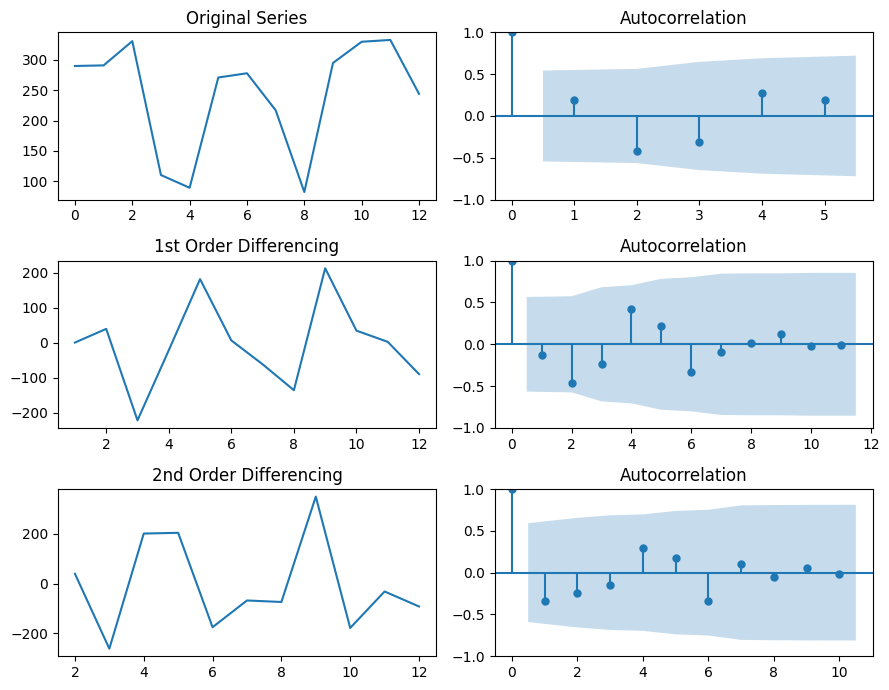

==================================================== ACF day_of_week 3 ====================================================


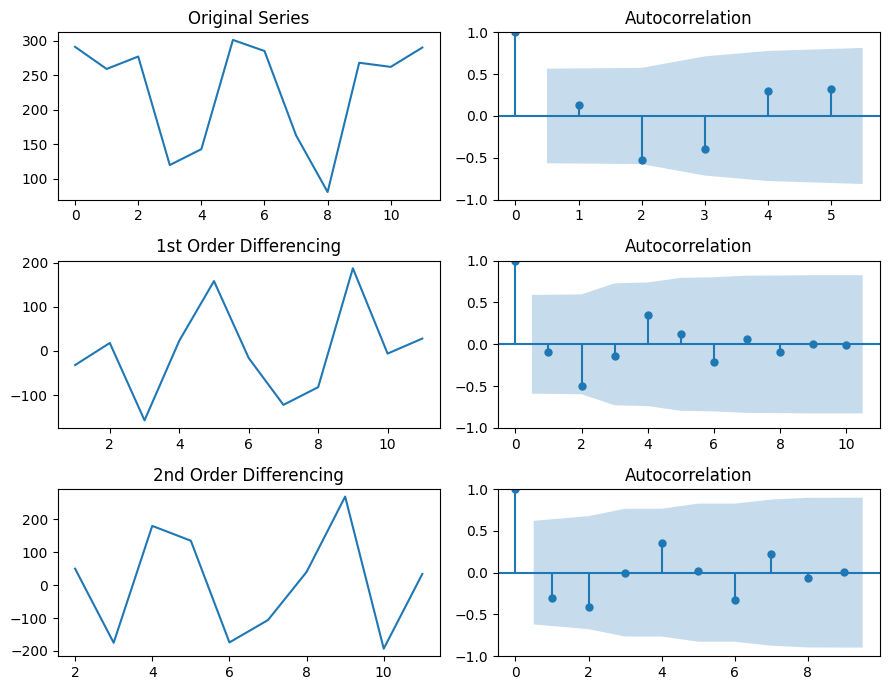

==================================================== ACF day_of_week 4 ====================================================


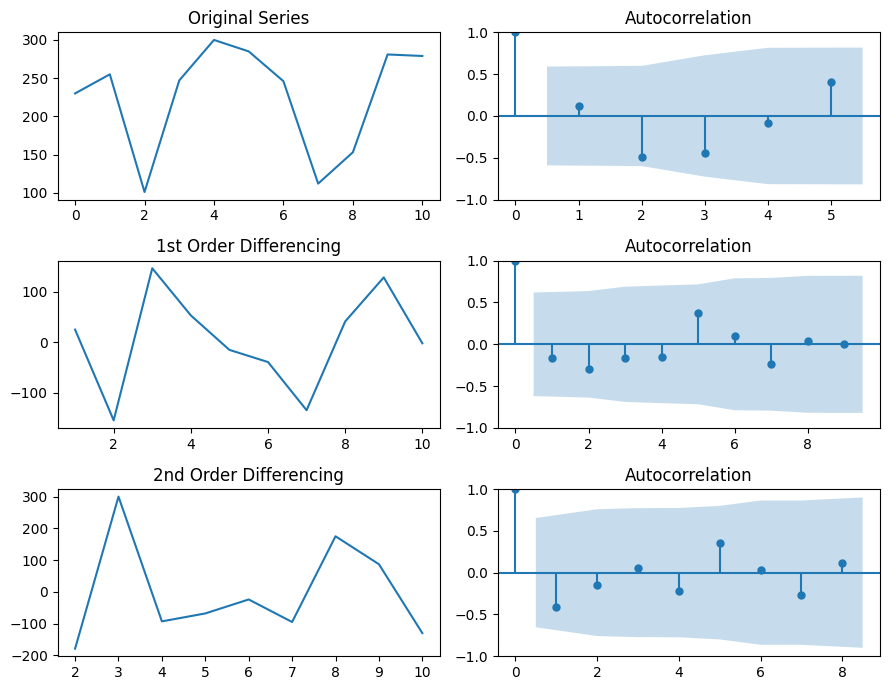

In [ ]:
for idx, df in enumerate(dfs_ARIMA):

    print('====================================================', 'ACF day_of_week',idx, '====================================================')

    plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':100})
    fig, axes = plt.subplots(3, 2, sharex=False)

    # Original Series
    axes[0, 0].plot(df.Volume); axes[0, 0].set_title('Original Series')
    plot_acf(df.Volume, ax=axes[0, 1], alpha=0.05, lags=5)

    # 1st Differencing
    axes[1, 0].plot(df.Volume.diff()); axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df.Volume.diff().dropna(), ax=axes[1, 1])

    # 2nd Differencing
    axes[2, 0].plot(df.Volume.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df.Volume.diff().diff().dropna(), ax=axes[2, 1])

    plt.tight_layout()
    plt.show()

Os graficos mostram que na primeira diferenciação a série já se torna super diferenciada (o que pode ser notado pela queda abrupta na curva de autocorrelação). Isso indica que o parâmetro d=1 é o ideal para todos os casos

#### Ordem da Auto-Regressão

Por se tratar de uma regressão feita sobre os valores anteriores da série vale conferir até que ponto há correlação entre os pontos de observação. Isso é definido através da Função de Autocorrelação Parcial (PACF).

============================================ PACF day_of_week 0 ============================================


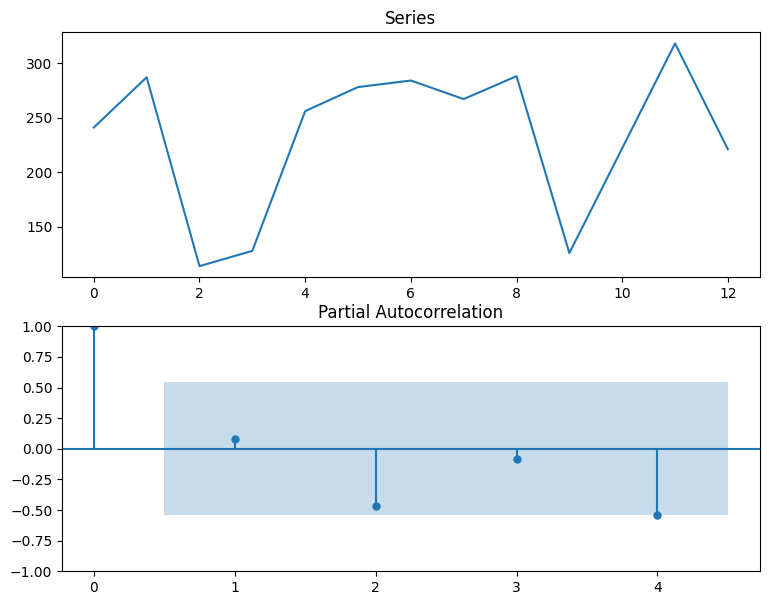

============================================ PACF day_of_week 1 ============================================


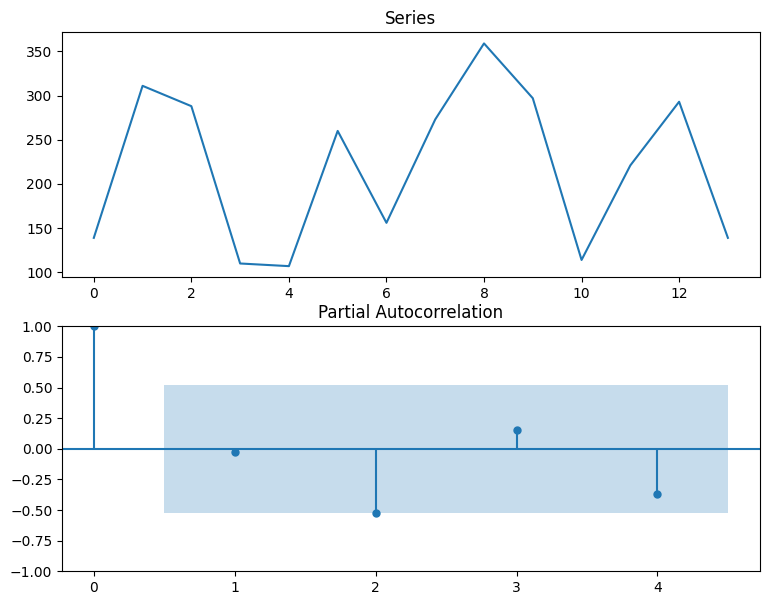

============================================ PACF day_of_week 2 ============================================


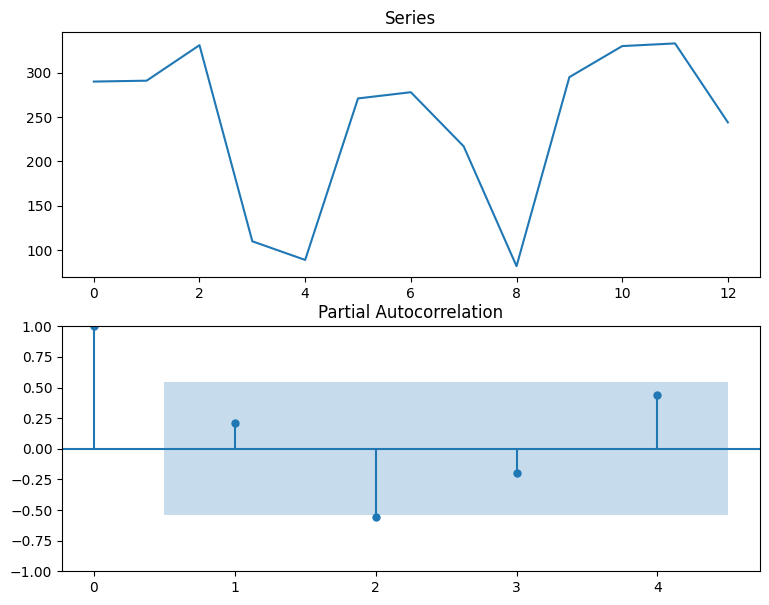

============================================ PACF day_of_week 3 ============================================


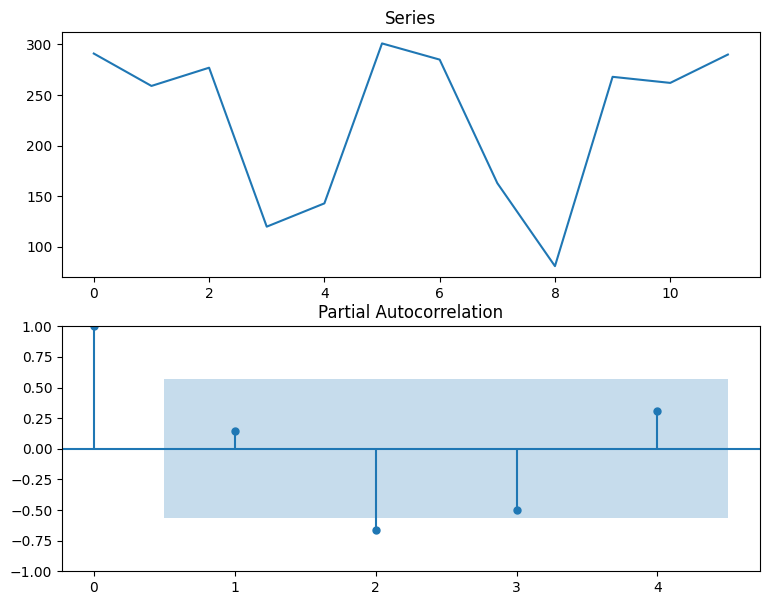

============================================ PACF day_of_week 4 ============================================


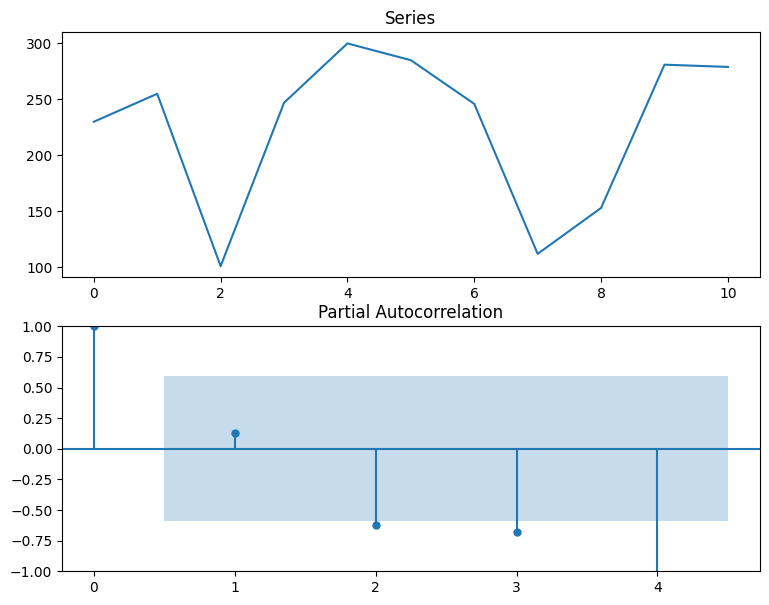

In [ ]:
# PACF
for idx, df in enumerate(dfs_ARIMA):

    print('============================================', 'PACF day_of_week',idx, '============================================')

    plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':100})
    fig, axes = plt.subplots(2, 1, sharex=False)
    axes[0].plot(df.Volume); axes[0].set_title('Series')
    axes[1].set(ylim=(0,1.5))
    plot_pacf(df.Volume, ax=axes[1], lags= 4)

    plt.show()

#### Ordem da Média-Móvel

O plot da ACF fornece um threshold, um limite, superior para o ordem do modelo MA. 

============================================ ACF day_of_week 0 ============================================


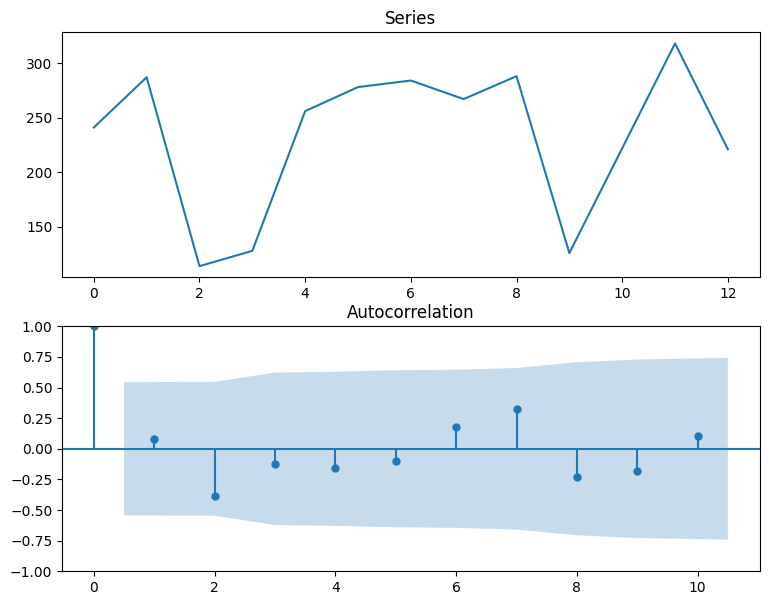

============================================ ACF day_of_week 1 ============================================


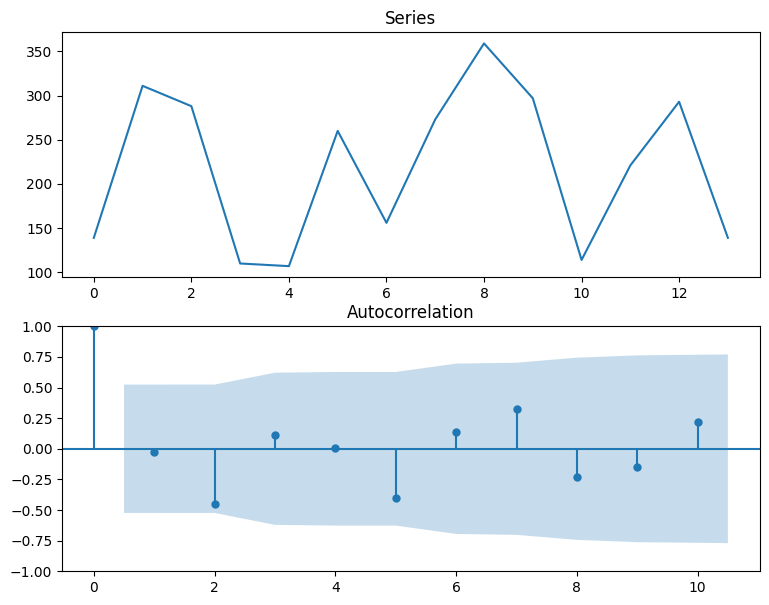

============================================ ACF day_of_week 2 ============================================


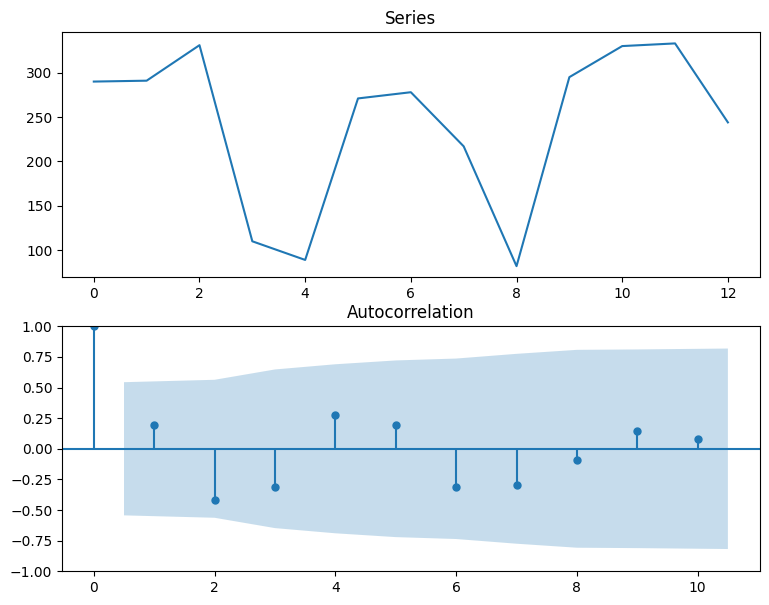

============================================ ACF day_of_week 3 ============================================


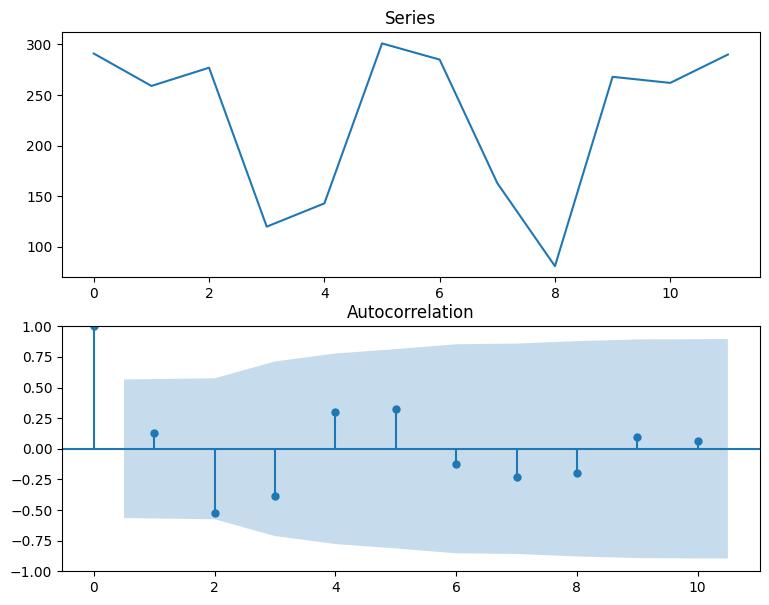

============================================ ACF day_of_week 4 ============================================


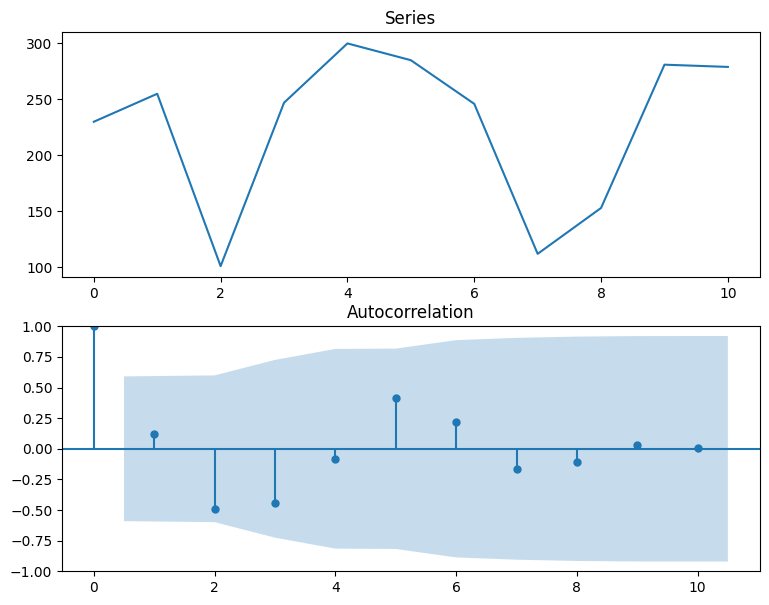

In [ ]:
# PACF
for idx, df in enumerate(dfs_ARIMA):

    print('============================================', 'ACF day_of_week',idx, '============================================')

    fig, axes = plt.subplots(2,1, sharex=False)


    axes[0].plot(df.Volume); axes[0].set_title('Series')
    plot_acf(df.Volume, ax=axes[1], lags=10)
    plt.show()



Nos modelos ARIMA, a componente de média móvel raramente ultrapassa 3 ou 4. Por isso, utilizaremos o valor 2 para manter o modelo simples.

#### Modelagem

============================================ ACF day_of_week 0 ============================================
============================================ ACF day_of_week 1 ============================================
============================================ ACF day_of_week 2 ============================================
============================================ ACF day_of_week 3 ============================================
============================================ ACF day_of_week 4 ============================================


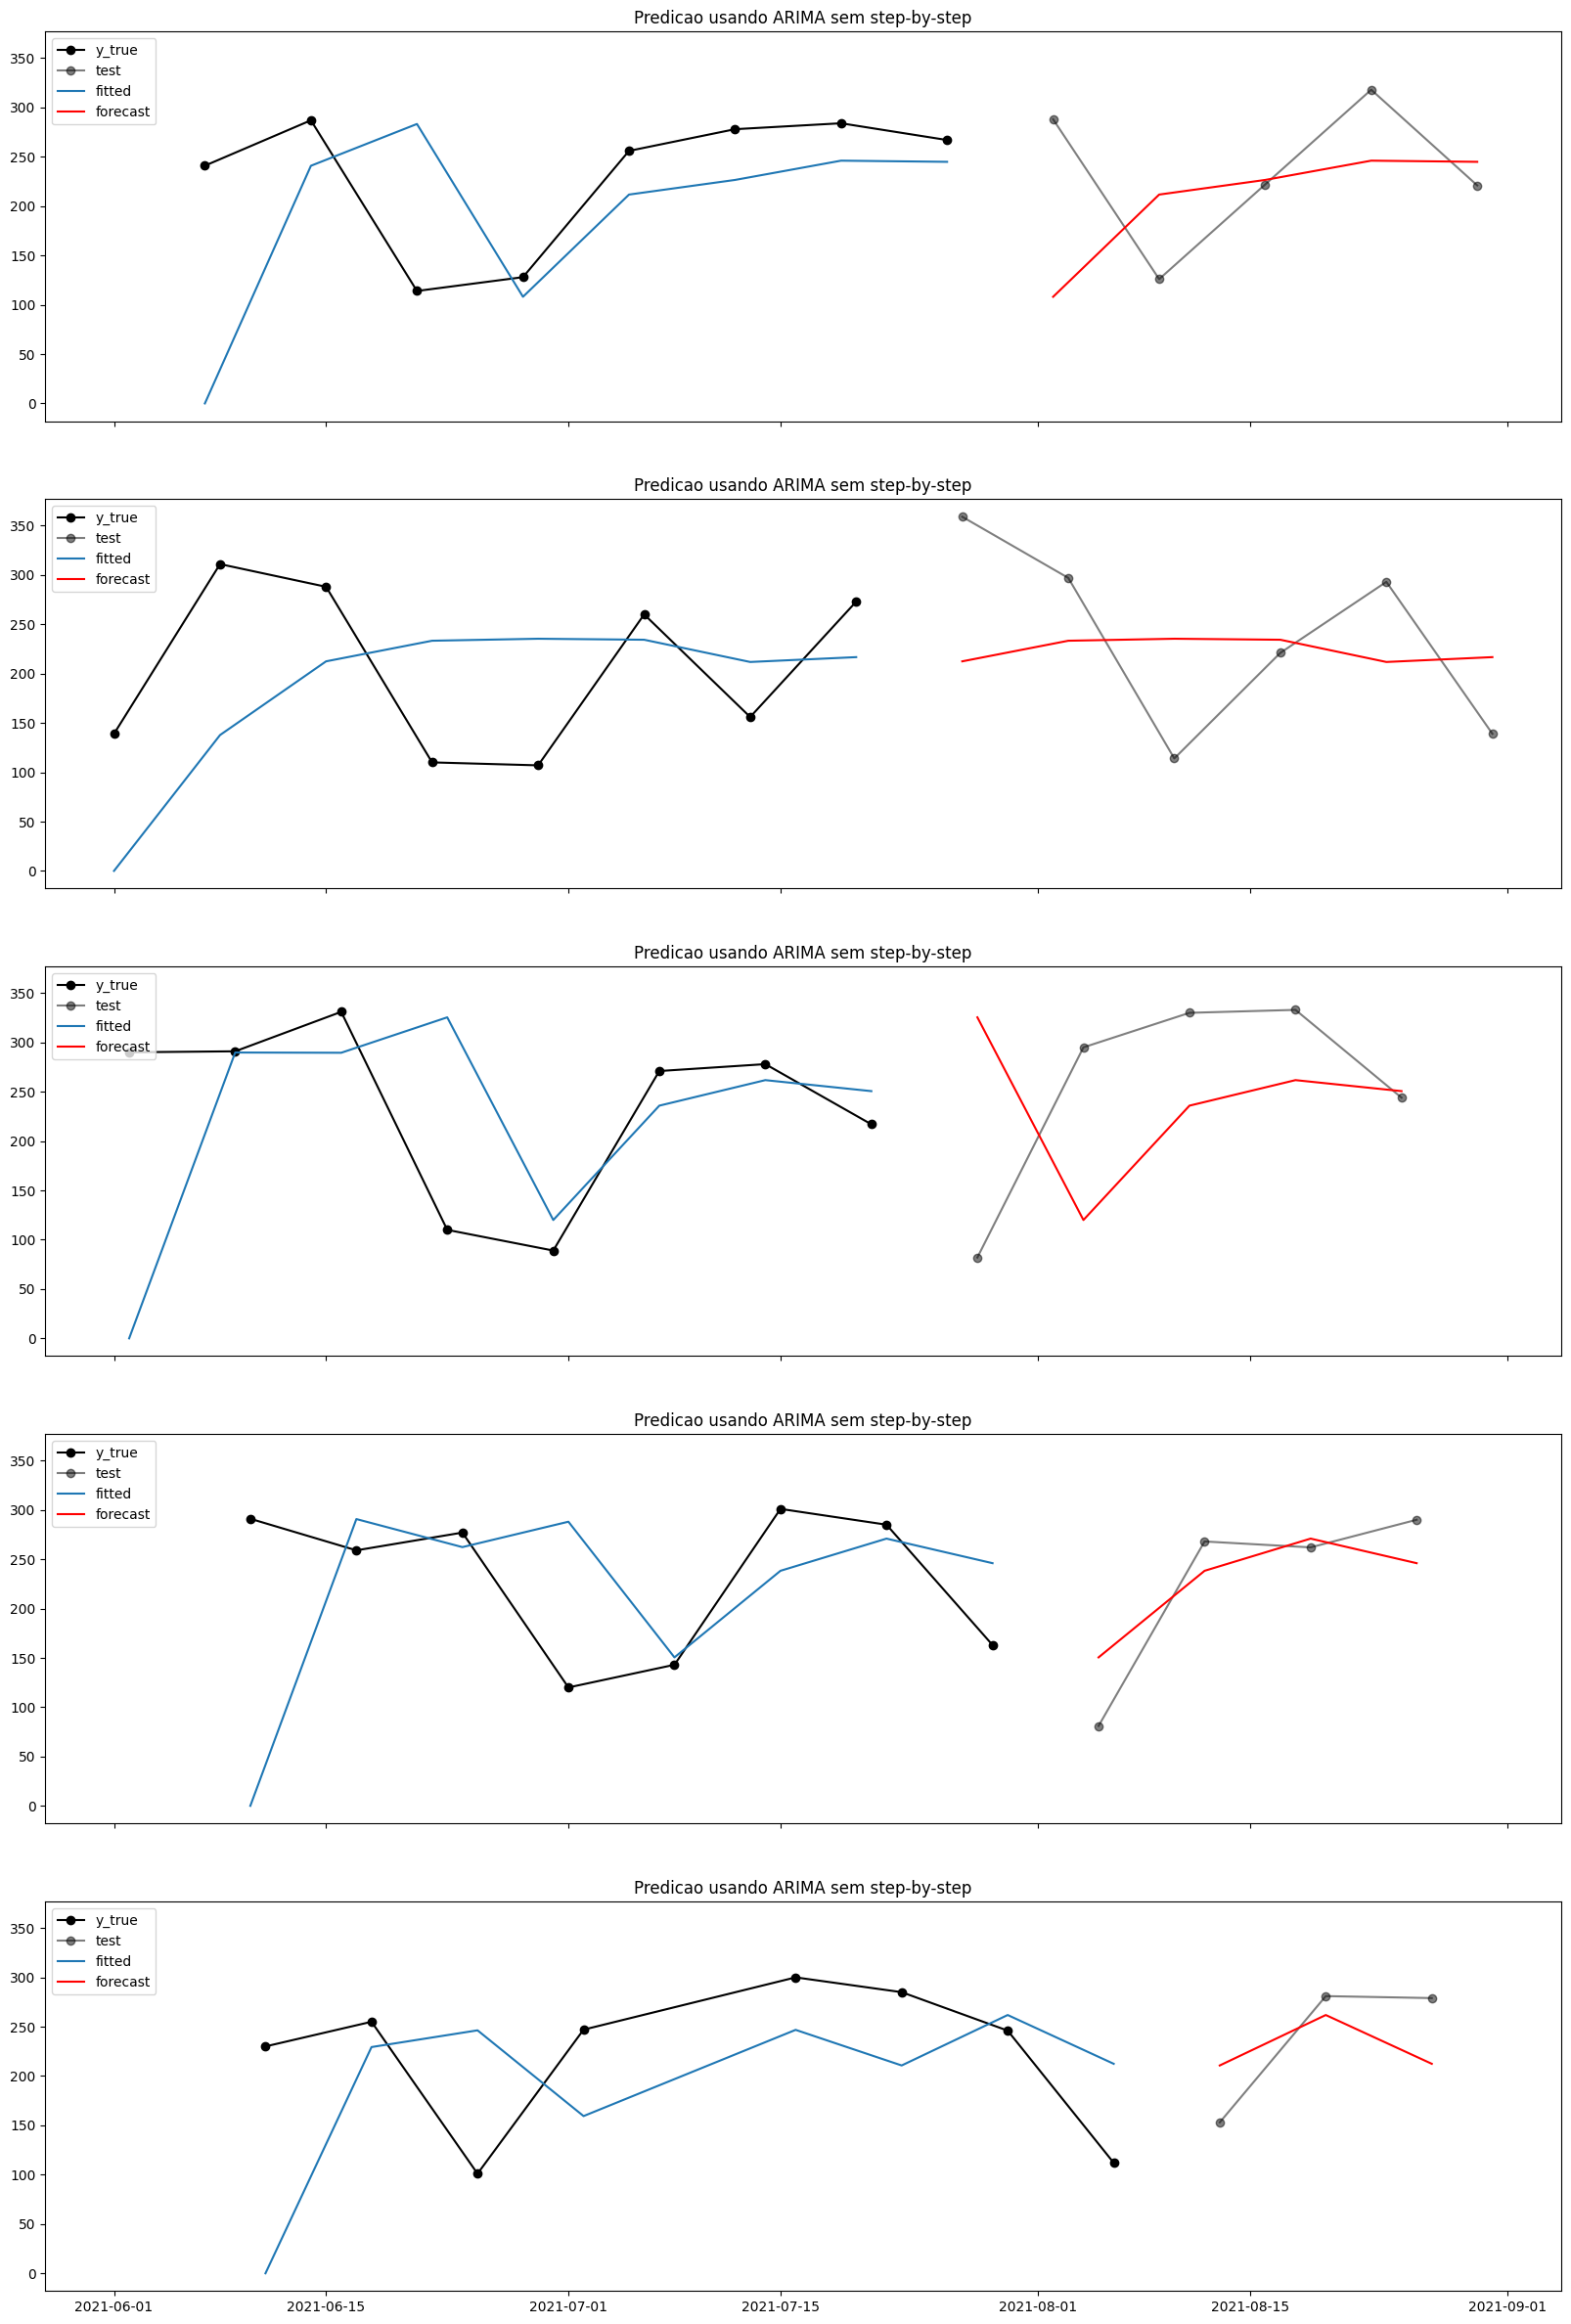

In [ ]:
p = 1 #Autoregressao
d = 1 #Diferenciacao
q = 2 #MediaMovel
# steps = 5 # Steps a serem previstos

fig, ax = plt.subplots(nrows=5,figsize=(20,30), sharex= True, sharey = True)
# Instancia o modelo e faz o fit no treino
for idx, df in enumerate(dfs_ARIMA):

    print('============================================', 'ACF day_of_week',idx, '============================================')


    model = ARIMA(df['Volume'][:8],order=(p,d,q)).fit()

# Realiza FORECAST
    if idx == 0:
        fc = model.predict(3, alpha=0.05)  # 95% conf
    if idx == 1:
        fc = model.predict(2, alpha=0.05)  # 95% conf
    if idx == 2:
        fc = model.predict(3, alpha=0.05)  # 95% conf
    if idx == 3:
        fc = model.predict(4, alpha=0.05)  # 95% conf
    if idx == 4:
        fc = model.predict(5, alpha=0.05)  # 95% conf

# Plot
    ax[idx].plot(df['Data'][:8],df['Volume'][:8], marker="o", color="black")

    ax[idx].plot(df['Data'][8:],df['Volume'][8:], marker="o", color="black", alpha = 0.5)

    ax[idx].plot(df['Data'][:8],model.fittedvalues)

    ax[idx].plot(df['Data'][8:],fc, color='red')

    ax[idx].legend(loc = 'upper left', labels = ['y_true','test', 'fitted', 'forecast'])

    ax[idx].set_title('Predicao usando ARIMA sem step-by-step')

plt.show()


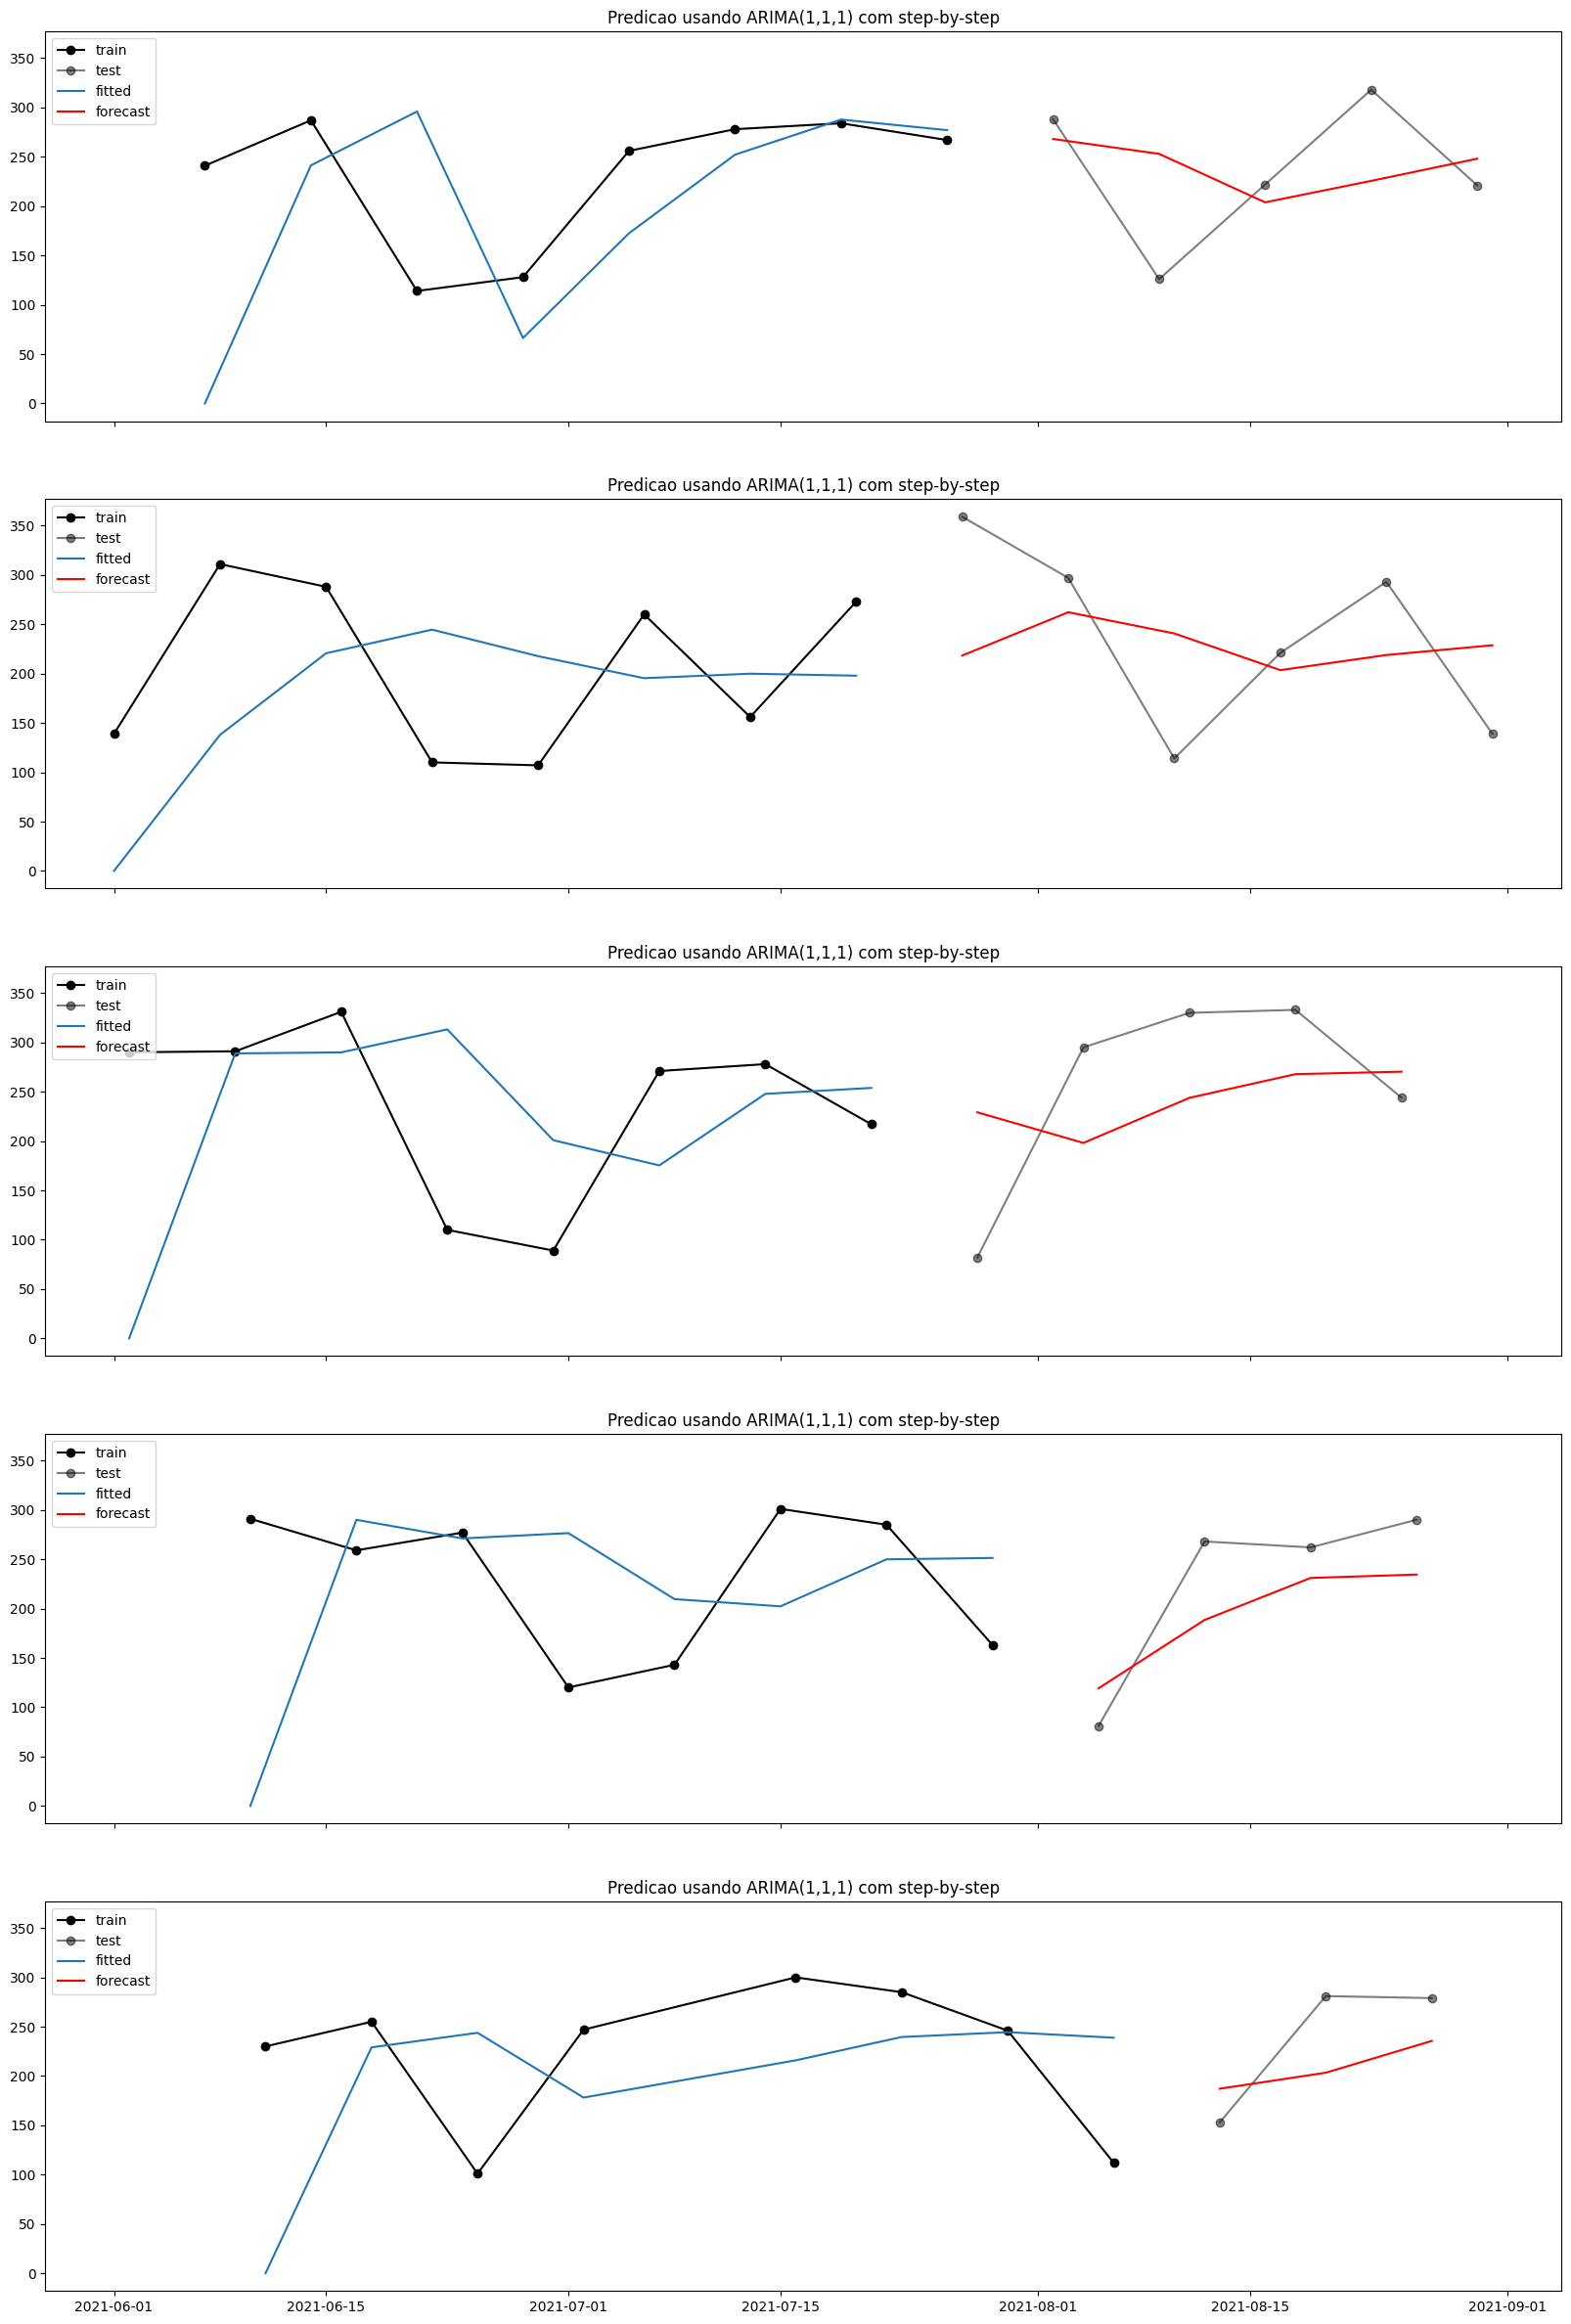

In [ ]:
p = 1 #Autoregressao
d = 1 #Diferenciacao
q = 1 #MediaMovel
# steps = 5 # Steps a serem previstos

fig, ax = plt.subplots(nrows=5,figsize=(20,30), sharex= True, sharey = True)

# Instancia o modelo e faz o fit no treino
for idx, df in enumerate(dfs_ARIMA):

    results = list()
    df_results_ARIMA = pd.DataFrame()

    for i in range(8, df.shape[0]+1):
        
        X = df.iloc[:i]

        ### primeiro adiciona aos resultados os valores de treinamento
        ### Esse passo tambem determina o parameto de suavizacao para o step by step
        if i == 8:
            ARIMA_base = ARIMA(X['Volume'],order=(p,d,q)).fit()
            [results.append(ARIMA_base.fittedvalues[i]) for i in range(len(ARIMA_base.fittedvalues))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            ARIMA_step = ARIMA(X['Volume'],order=(p,d,q)).fit()
            results.append(ARIMA_step.fittedvalues[i-1])

    df_results_ARIMA = pd.concat([X,pd.Series(results)], axis = 1, ignore_index = True)

    df = pd.concat([df,pd.Series(results, name = 'ARIMA')], axis = 1, ignore_index = True)
    df.columns = ['DOW', 'Data', 'y_true', 'y_pred']
    dfs_ARIMA[idx] = df.copy()

    ax[idx].plot(df['Data'][:8],df['y_true'][:8], marker="o", color="black")
    ax[idx].plot(df['Data'][8:],df['y_true'][8:], marker="o", color="black", alpha = 0.5)

    ax[idx].plot(df['Data'][:8],df['y_pred'][:8])

    ax[idx].plot(df['Data'][8:],df['y_pred'][8:], color= 'red')


    ax[idx].set_title('Predicao usando ARIMA(1,1,1) com step-by-step')
    ax[idx].legend(loc = 'upper left', labels = ['train', 'test','fitted','forecast'])


### calculo do erro

In [ ]:
print('DF0 = Segundas')
print('DF1 = Tercas')
print('DF2 = Quartas')
print('DF3 = Quintas')
print('DF4 = Sextas')
print()
print()

for idx, df in enumerate(dfs_ARIMA):
    print('=================================================', 'errors day_of_week',idx,'=================================================')

    print('\t erro (RMSE) da previsao \t',
            mean_squared_error( dfs_ARIMA[idx]['y_true'][8:],
                                dfs_ARIMA[idx]['y_pred'][8:],
                                squared=False))


DF0 = Segundas
DF1 = Tercas
DF2 = Quartas
DF3 = Quintas
DF4 = Sextas


================================================= errors day_of_week 0 =================================================
	 erro (RMSE) da previsao 	 72.27165132419812
================================================= errors day_of_week 1 =================================================
	 erro (RMSE) da previsao 	 92.11771110168313
================================================= errors day_of_week 2 =================================================
	 erro (RMSE) da previsao 	 93.16526923498094
================================================= errors day_of_week 3 =================================================
	 erro (RMSE) da previsao 	 54.38029819490982
================================================= errors day_of_week 4 =================================================
	 erro (RMSE) da previsao 	 55.0215641388355
